In [1]:
from turtle import shape
import nibabel as nib
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import pandas as pd
import imblearn
import re
import seaborn as sns
import math
import random
from numpy import linalg as LA

# Setting paths for different folders
FLAIR_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar'
T1_Lacunes_Incorrect = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space.tar'
T1_Lacunes_Correct = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\lacune_T1space_JiyangCorrected20210920'
T1_scan = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1_withLacunes_35.tar'
T1_Soft_Tissue = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\T1softTiss_withLacunes_35.tar'
T1_Soft_Tissue_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35.tar'
T1_Soft_Tissue_Binary_Mask = r'C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Original\T1softTissMask_withLacunes_35_binary.tar'


In [2]:
#CSF, GM, WM
tissue_maps = r'C:\Users\ellen\Downloads\tissue_prob_maps.tar\tissue_prob_maps'
CSF = []
WM = []
GM = []
for file in os.listdir(tissue_maps):
    if file.endswith(".nii.gz"):
        if file.find("CSF"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            CSF.append(Data_list)
        if file.find("GM"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            WM.append(Data_list)
        if file.find("WM"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(tissue_maps, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            GM.append(Data_list)

In [139]:
T1_scan_data[0][1].shape

(256, 256, 190)

In [3]:
def read_data():
    #Read all data into list
    T1_scan_data = []
    for file in os.listdir(T1_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            T1_scan_data.append(Data_list)

    #Read all FLAIR data into list
    FLAIR_scan_data = []
    for file in os.listdir(FLAIR_scan):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(FLAIR_scan, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            FLAIR_scan_data.append(Data_list)

    #Lacune Exists
    Lacune_indicator_data = []
    for file in os.listdir(T1_Lacunes_Correct):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Lacunes_Correct, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Lacune_indicator_data.append(Data_list)

    Soft_tiss_data = []
    for file in os.listdir(T1_Soft_Tissue):
        if file.endswith(".nii.gz"):
            Data_list = []
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            Data_list.append(file_id)
            Data_list.append(data)
            Soft_tiss_data.append(Data_list)

    return T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data
T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data = read_data()
print("complete")

ZranError: zran_read returned error: ZRAN_READ_FAIL (file: C:\Users\ellen\Documents\ew-honoursthesis\Data\forAudrey.tar\Normalised\FLAIRinT1space_withLacunes_35.tar\r0891_tp2_flair.nii.gz)

In [ ]:
def sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_lacune = []
    Y_train_3D_lacune = []
    Y_train_segment_3D_lacune = []
    X_train_3D_nlacune = []
    Y_train_3D_nlacune = []
    Y_train_segment_3D_nlacune = []
    
    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]

            #Sample lacunes
            for x in range(0, data.shape[0]):
                for y in range(0, data.shape[1]):
                    for z in range(0, data.shape[2]):
                        #filter for soft tissue
                        if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165) | (T1_data_scans[x,y,z] == 0) | (FLAIR_data_scans[x,y,z] == 0):
                            next
                        else:
                    
                            if brain_image <= 24:
                                if (Lacune_data[x,y,z] == 1) & (sum(sum(sum(Lacune_data[x-1:x+1, y-1:y+1, z-1:z+1]))) >= 4):
                                    
                                    brain_values = []
                                    brain_values_nlacune = []
                                    brain_values_rot90x = []
                                    brain_values_rot90y = []
                                    brain_values_rot90z = []
                                    brain_values_rot180x = []
                                    brain_values_rot180y = []
                                    brain_values_rot180z = []
                                    brain_values_rot270x = []
                                    brain_values_rot270y = []
                                    brain_values_rot270z = []

                                    brain_values.append(file_id)
                                    brain_values_nlacune.append(file_id)
                                    brain_values_rot90x.append(file_id)
                                    brain_values_rot90y.append(file_id)
                                    brain_values_rot90z.append(file_id)
                                    brain_values_rot180x.append(file_id)
                                    brain_values_rot180y.append(file_id)
                                    brain_values_rot180z.append(file_id)
                                    brain_values_rot270x.append(file_id)
                                    brain_values_rot270y.append(file_id)
                                    brain_values_rot270z.append(file_id)

                                    brain_values.append(x)
                                    brain_values_nlacune.append(256-x)
                                    brain_values_rot90x.append(x)
                                    brain_values_rot90y.append(x)
                                    brain_values_rot90z.append(x)
                                    brain_values_rot180x.append(x)
                                    brain_values_rot180y.append(x)
                                    brain_values_rot180z.append(x)
                                    brain_values_rot270x.append(x)
                                    brain_values_rot270y.append(x)
                                    brain_values_rot270z.append(x)

                                    brain_values.append(y)
                                    brain_values_nlacune.append(y)
                                    brain_values_rot90x.append(y)
                                    brain_values_rot90y.append(y)
                                    brain_values_rot90z.append(y)
                                    brain_values_rot180x.append(y)
                                    brain_values_rot180y.append(y)
                                    brain_values_rot180z.append(y)
                                    brain_values_rot270x.append(y)
                                    brain_values_rot270y.append(y)
                                    brain_values_rot270z.append(y)

                                    brain_values.append(z)
                                    brain_values_nlacune.append(z)
                                    brain_values_rot90x.append(z)
                                    brain_values_rot90y.append(z)
                                    brain_values_rot90z.append(z)
                                    brain_values_rot180x.append(z)
                                    brain_values_rot180y.append(z)
                                    brain_values_rot180z.append(z)
                                    brain_values_rot270x.append(z)
                                    brain_values_rot270y.append(z)
                                    brain_values_rot270z.append(z)

                                    patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_T1_nlacune = T1_data_scans[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_T1)
                                    brain_values_nlacune.append(patch_3D_T1_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_T1, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_T1, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_T1, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_T1, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_T1, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_T1, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_T1, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_T1, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_T1, k=3, axes=(0,2)))


                                    patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_FLAIR_nlacune = FLAIR_data_scans[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_FLAIR)
                                    brain_values_nlacune.append(patch_3D_FLAIR_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_FLAIR, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_FLAIR, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_FLAIR, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_FLAIR, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_FLAIR, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_FLAIR, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_FLAIR, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_FLAIR, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_FLAIR, k=3, axes=(0,2)))

                                    patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_softtiss_binary_nlacune = data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_softtiss_binary)
                                    brain_values_nlacune.append(patch_3D_softtiss_binary_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_softtiss_binary, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_softtiss_binary, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_softtiss_binary, k=3, axes=(0,2)))

                                    patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_softtiss_nlacune = SoftTiss[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_softtiss)
                                    brain_values_nlacune.append(patch_3D_softtiss_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_softtiss, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_softtiss, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_softtiss, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_softtiss, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_softtiss, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_softtiss, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_softtiss, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_softtiss, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_softtiss, k=3, axes=(0,2)))
                                    
                                    patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_CSF_nlacune = CSF_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_CSF)
                                    brain_values_nlacune.append(patch_3D_CSF_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_CSF, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_CSF, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_CSF, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_CSF, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_CSF, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_CSF, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_CSF, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_CSF, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_CSF, k=3, axes=(0,2)))
                                    
                                    patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_WM_nlacune = WM_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_WM)
                                    brain_values_nlacune.append(patch_3D_WM_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_WM, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_WM, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_WM, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_WM, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_WM, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_WM, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_WM, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_WM, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_WM, k=3, axes=(0,2)))
                                    
                                    patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                                    patch_3D_GM_nlacune = GM_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    brain_values.append(patch_3D_GM)
                                    brain_values_nlacune.append(patch_3D_GM_nlacune)
                                    brain_values_rot90x.append(np.rot90(patch_3D_GM, k=1, axes=(0,1)))
                                    brain_values_rot90y.append(np.rot90(patch_3D_GM, k=1, axes=(1,2)))
                                    brain_values_rot90z.append(np.rot90(patch_3D_GM, k=1, axes=(0,2)))
                                    brain_values_rot180x.append(np.rot90(patch_3D_GM, k=2, axes=(0,1)))
                                    brain_values_rot180y.append(np.rot90(patch_3D_GM, k=2, axes=(1,2)))
                                    brain_values_rot180z.append(np.rot90(patch_3D_GM, k=2, axes=(0,2)))
                                    brain_values_rot270x.append(np.rot90(patch_3D_GM, k=3, axes=(0,1)))
                                    brain_values_rot270y.append(np.rot90(patch_3D_GM, k=3, axes=(1,2)))
                                    brain_values_rot270z.append(np.rot90(patch_3D_GM, k=3, axes=(0,2)))

                                    #brain_rotation
                                    lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10] 
                                    lacune_binary_nlacune = Lacune_data[(256-x)-10:(256-x)+10, y-10:y+10, z-10:z+10]
                                    lacune_binary_rot90x = np.rot90(lacune_binary, k=1, axes=(0,1))
                                    lacune_binary_rot90y = np.rot90(lacune_binary, k=1, axes=(1,2))
                                    lacune_binary_rot90z = np.rot90(lacune_binary, k=1, axes=(0,2))
                                    lacune_binary_rot180x = np.rot90(lacune_binary, k=2, axes=(0,1))
                                    lacune_binary_rot180y = np.rot90(lacune_binary, k=2, axes=(1,2))
                                    lacune_binary_rot180z = np.rot90(lacune_binary, k=2, axes=(0,2))
                                    lacune_binary_rot270x = np.rot90(lacune_binary, k=3, axes=(0,1))
                                    lacune_binary_rot270y = np.rot90(lacune_binary, k=3, axes=(1,2))
                                    lacune_binary_rot270z = np.rot90(lacune_binary, k=3, axes=(0,2))

                                    X_train_3D_lacune.append(brain_values)
                                    X_train_3D_nlacune.append(brain_values_nlacune)
                                    X_train_3D_lacune.append(brain_values_rot90x)
                                    X_train_3D_lacune.append(brain_values_rot90y)
                                    X_train_3D_lacune.append(brain_values_rot90z)
                                    X_train_3D_lacune.append(brain_values_rot180x)
                                    X_train_3D_lacune.append(brain_values_rot180y)
                                    X_train_3D_lacune.append(brain_values_rot180z)
                                    X_train_3D_lacune.append(brain_values_rot270x)
                                    X_train_3D_lacune.append(brain_values_rot270y)
                                    X_train_3D_lacune.append(brain_values_rot270z)
                                    
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_nlacune.append(0)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    Y_train_3D_lacune.append(1)
                                    
                                    Y_train_segment_3D_lacune.append(lacune_binary)
                                    Y_train_segment_3D_nlacune.append(lacune_binary_nlacune)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot90z)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot180z)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270x)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270y)
                                    Y_train_segment_3D_lacune.append(lacune_binary_rot270z)
                                    
                                    print("appended a sample")
                            
            brain_image += 1
            print(brain_image)
    return X_train_3D_lacune, Y_train_3D_lacune, Y_train_segment_3D_lacune, X_train_3D_nlacune, Y_train_3D_nlacune, Y_train_segment_3D_nlacune
X_train_3D_lacune, Y_train_3D_lacune, Y_train_segment_3D_lacune, X_train_3D_nlacune, Y_train_3D_nlacune, Y_train_segment_3D_nlacune = sample_lacunes(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

In [ ]:
def non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_train_3D_nlacune_func2 = []
    Y_train_3D_nlacune_func2 = []
    Y_train_segment_3D_nlacune_func2 = []

    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]
            
            #Sample lacunes
            sampled_list_x = np.random.choice(data.shape[0], 2500)
            sampled_list_y = np.random.choice(data.shape[1], 2500)
            sampled_list_z = np.random.choice(data.shape[2], 2500)
            for x,y,z in set(list(zip(sampled_list_x, sampled_list_y,sampled_list_z))):
                #filter for soft tissue
                if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165) |  (T1_data_scans[x,y,z] == 0) | (FLAIR_data_scans[x,y,z] == 0):
                    next
                else:
                    brain_values = []
                    brain_values.append(file_id)
                    brain_values.append(x)
                    brain_values.append(y)
                    brain_values.append(z)

                    patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_T1)

                    patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_FLAIR)

                    patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_softtiss_binary)

                    patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_softtiss)

                    patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_CSF)

                    patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_WM)

                    patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                    brain_values.append(patch_3D_GM)

                    lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10]

                    if brain_image <= 24:
                        # No lacune exists in the 3D patch, add to train set
                        if any(1 in sublist for sublist in lacune_binary):
                            next
                        else:
                            X_train_3D_nlacune_func2.append(brain_values)
                            Y_train_3D_nlacune_func2.append(0)
                            Y_train_segment_3D_nlacune_func2.append(lacune_binary)
                                    
            brain_image += 1
            print(brain_image)

    return X_train_3D_nlacune_func2, Y_train_3D_nlacune_func2, Y_train_segment_3D_nlacune_func2
X_train_3D_nlacune_func2, Y_train_3D_nlacune_func2, Y_train_segment_3D_nlacune_func2 = non_lacune_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

In [ ]:
def test_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data):
    # Lacune not as centred, random sampling all around brain
    X_test_3D_nlacune = []
    Y_test_3D_nlacune = []
    Y_test_segment_3D_nlacune = []
    X_test_3D_lacune = []
    Y_test_3D_lacune = []
    Y_test_segment_3D_lacune = []
    brain_image = 0
    for file in os.listdir(T1_Soft_Tissue_Binary_Mask):
        if file.endswith(".nii.gz"):
            file_id = int(re.search(r'\d+', file)[0])
            imgpath = os.path.join(T1_Soft_Tissue_Binary_Mask, file)
            img = nib.load(imgpath)
            data = img.get_fdata()
            data = data.astype(np.uint8)  # converting array of ints to floats
            T1_data_scans = T1_scan_data[brain_image][1]
            FLAIR_data_scans = FLAIR_scan_data[brain_image][1]
            SoftTiss = Soft_tiss_data[brain_image][1]
            Lacune_data = Lacune_indicator_data[brain_image][1]
            CSF_data = CSF[brain_image][1]
            GM_data = GM[brain_image][1]
            WM_data = WM[brain_image][1]
            
            #Sample lacunes
            #Sample lacunes
            sampled_list_x = np.random.choice(data.shape[0], 15000)
            sampled_list_y = np.random.choice(data.shape[1], 15000)
            sampled_list_z = np.random.choice(data.shape[2], 15000)
            for x,y,z in set(list(zip(sampled_list_x, sampled_list_y,sampled_list_z))):
                #filter for soft tissue
                if (x < 50) | (y < 70) | (z < 15) | (x > 200) | (y > 210) | (z > 165) | (T1_data_scans[x,y,z] == 0) | (FLAIR_data_scans[x,y,z] == 0):
                    next
                else:
                    if brain_image <= 24:
                        next

                    else:
                        brain_values = []
                        brain_values.append(file_id)
                        brain_values.append(x)
                        brain_values.append(y)
                        brain_values.append(z)

                        patch_3D_T1 = T1_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_T1)

                        patch_3D_FLAIR = FLAIR_data_scans[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_FLAIR)

                        patch_3D_softtiss_binary = data[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_softtiss_binary)

                        patch_3D_softtiss = SoftTiss[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_softtiss)

                        patch_3D_CSF = CSF_data[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_CSF)

                        patch_3D_WM = WM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_WM)

                        patch_3D_GM = GM_data[x-10:x+10, y-10:y+10, z-10:z+10]
                        brain_values.append(patch_3D_GM)

                        lacune_binary = Lacune_data[x-10:x+10, y-10:y+10, z-10:z+10]

                        lacune_centre = Lacune_data[x-1:x+1, y-1:y+1, z-1:z+1]
                        if any(1 in sublist for sublist in lacune_centre):
                            print(lacune_centre)
                            X_test_3D_lacune.append(brain_values)
                            Y_test_3D_lacune.append(1)
                            Y_test_segment_3D_lacune.append(lacune_binary)
                        else:
                            X_test_3D_nlacune.append(brain_values)
                            Y_test_3D_nlacune.append(0)
                            Y_test_segment_3D_nlacune.append(lacune_binary)
            brain_image += 1
            print(brain_image)

    return X_test_3D_lacune, Y_test_3D_lacune, Y_test_segment_3D_lacune, X_test_3D_nlacune, Y_test_3D_nlacune, Y_test_segment_3D_nlacune
X_test_3D_lacune, Y_test_3D_lacune, Y_test_segment_3D_lacune, X_test_3D_nlacune, Y_test_3D_nlacune, Y_test_segment_3D_nlacune = test_sampling(T1_scan_data, FLAIR_scan_data, Lacune_indicator_data, Soft_tiss_data)

In [ ]:
X_train_3D_nlacune_all = np.concatenate((X_train_3D_nlacune, X_train_3D_nlacune_func2), axis=0)
Y_train_3D_nlacune_all = np.concatenate((Y_train_3D_nlacune, Y_train_3D_nlacune_func2), axis=0)
Y_train_segment_3D_nlacune_all = np.concatenate((Y_train_segment_3D_nlacune, Y_train_segment_3D_nlacune_func2), axis=0)
print(len(X_train_3D_nlacune_all))
print(len(Y_train_3D_nlacune_all))
print(len(X_train_3D_lacune))
print(len(Y_train_3D_lacune))
print("done")

In [51]:
len(X_train_3D_nlacune_all)

17713

In [ ]:
X_train = np.concatenate((X_train_3D_lacune, X_train_3D_nlacune_all), axis=0)
Y_train = np.concatenate((Y_train_3D_lacune, Y_train_3D_nlacune_all), axis=0)
Y_train_segment = np.concatenate((Y_train_segment_3D_lacune, Y_train_segment_3D_nlacune_all), axis=0)
Y_test_segment = np.concatenate((Y_test_segment_3D_lacune, Y_test_segment_3D_nlacune), axis=0)
print(len(X_train_3D_nlacune_all))
print(len(X_train_3D_lacune))
print("done")

In [186]:
len(Y_test)

37839

In [10]:
print(len(X_test_3D_nlacune))
print(len(X_test_3D_lacune))
print("done")

37892
4
done


In [13]:
Y_test = np.concatenate((Y_test_3D_lacune, Y_test_3D_nlacune), axis=0)
X_test = np.concatenate((X_test_3D_lacune, X_test_3D_nlacune), axis=0)

In [150]:
print(X_train_3D_lacune[0])

[46, 105, 148, 104, array([[[0.47674233, 0.47276786, 0.43993714, ..., 0.50492787,
         0.49172994, 0.46971387],
        [0.45867601, 0.47604445, 0.46519032, ..., 0.5294919 ,
         0.49789804, 0.4303377 ],
        [0.47531331, 0.46479896, 0.4524734 , ..., 0.52732277,
         0.49779242, 0.43813661],
        ...,
        [0.39114425, 0.4277502 , 0.47274119, ..., 0.53217286,
         0.53128469, 0.51578903],
        [0.37016004, 0.45876497, 0.51360559, ..., 0.51132178,
         0.53656322, 0.54083687],
        [0.40444723, 0.46686184, 0.50754899, ..., 0.53696907,
         0.52197856, 0.51767004]],

       [[0.47590271, 0.442734  , 0.41514146, ..., 0.50106597,
         0.48061097, 0.47466698],
        [0.50180793, 0.50031573, 0.47791395, ..., 0.50634736,
         0.50202441, 0.4575763 ],
        [0.4973377 , 0.49022493, 0.48938546, ..., 0.52026057,
         0.48217329, 0.42528692],
        ...,
        [0.42808831, 0.4009009 , 0.44492117, ..., 0.52427942,
         0.52979982, 0.532

In [ ]:
x,y,z = Lacune_indicator_data[0][1].nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
Lacune_indicator_data[0][1]

In [ ]:
m1 = np.rot90(Lacune_indicator_data[0][1], axes=(0,1))
m2 = np.rot90(Lacune_indicator_data[0][1], axes=(1,2))
m3 = np.rot90(Lacune_indicator_data[0][1], axes=(0,2))

In [ ]:
x,y,z = m1.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
x,y,z = m2.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [ ]:
x,y,z = m3.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0,256)
ax.set_ylim(0, 256)
ax.set_zlim(0, -180)
plt.savefig("demo.png")

In [185]:
H_all_T1 = np.array([np.gradient(i) for i in np.gradient(X_train[index][4])]).transpose(2,3,4,0,1)
LA.eig(H_all_T1[10, 10, 10])[0][0]

0.12976501741036717

In [ ]:
print('hello')

In [17]:
#Features
filterSize =(16,16)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,filterSize)

min_T1 = []
med_T1 = []
mid_T1 = []
mid_vsmall_ratio_T1 = []
mid_small_ratio_T1 = []
mid_med_ratio_T1 = []
mid_large_ratio_T1 = []
mid_vsmall_ratio_T1_inc = []
mid_small_ratio_T1_inc = []
mid_med_ratio_T1_inc = []
mid_large_ratio_T1_inc = []
mean_T1 = []
max_T1 = []
var_T1 = []
range_T1 = []
H_T1_e1 = []
H_T1_e2 = []
H_T1_e3 = []

min_FLAIR = []
med_FLAIR = []
mid_FLAIR = []
mid_vsmall_ratio_FLAIR = []
mid_small_ratio_FLAIR = []
mid_med_ratio_FLAIR = []
mid_large_ratio_FLAIR = []
mid_vsmall_ratio_FLAIR_inc = []
mid_small_ratio_FLAIR_inc = []

mid_med_ratio_FLAIR_inc = []
mid_large_ratio_FLAIR_inc = []
mean_FLAIR = []
max_FLAIR = []
var_FLAIR = []
range_FLAIR = []
H_FLAIR_e1 = []
H_FLAIR_e2 = []
H_FLAIR_e3 = []

density_diff = []
sum_soft_tiss_binary = []
sum_percent_soft_tiss = []

min_st = []
med_st = []
mid_st = []
mid_vsmall_ratio_st = []
mid_small_ratio_st = []
mid_med_ratio_st = []
mid_large_ratio_st = []
mid_vsmall_ratio_st_inc = []
mid_small_ratio_st_inc = []
mid_med_ratio_st_inc = []
mid_large_ratio_st_inc = []
mean_st = []
max_st = []
var_st = []
range_st = []
H_st_e1 = []
H_st_e2 = []
H_st_e3 = []

min_stm = []
med_stm = []
mid_stm = []
mid_vsmall_ratio_stm = []
mid_small_ratio_stm = []
mid_med_ratio_stm = []
mid_large_ratio_stm = []
mid_vsmall_ratio_stm_inc = []
mid_small_ratio_stm_inc = []
mid_med_ratio_stm_inc = []
mid_large_ratio_stm_inc = []
mean_stm = []
max_stm = []
var_stm = []
range_stm = []
H_stm_e1 = []
H_stm_e2 = []
H_stm_e3 = []

min_th_T1 = []
med_th_T1 = []
mid_th_T1 = []
mid_vsmall_ratio_th_T1 = []
mid_small_ratio_th_T1 = []
mid_med_ratio_th_T1 = []
mid_large_ratio_th_T1 = []
mid_vsmall_ratio_th_T1_inc = []
mid_small_ratio_th_T1_inc = []
mid_med_ratio_th_T1_inc = []
mid_large_ratio_th_T1_inc = []
mean_th_T1 = []
max_th_T1 = []
var_th_T1 = []
range_th_T1 = []
H_th_T1_e1 = []
H_th_T1_e2 = []
H_th_T1_e3 = []


min_th_FLAIR = []
med_th_FLAIR = []
mid_th_FLAIR = []
mid_vsmall_ratio_th_FLAIR = []
mid_small_ratio_th_FLAIR = []
mid_med_ratio_th_FLAIR = []
mid_large_ratio_th_FLAIR = []
mid_vsmall_ratio_th_FLAIR_inc = []
mid_small_ratio_th_FLAIR_inc = []
mid_med_ratio_th_FLAIR_inc = []
mid_large_ratio_th_FLAIR_inc = []
mean_th_FLAIR = []
max_th_FLAIR = []
var_th_FLAIR = []
range_th_FLAIR = []
H_th_FLAIR_e1 = []
H_th_FLAIR_e2 = []
H_th_FLAIR_e3 = []


min_th_st = []
med_th_st = []
mid_th_st = []
mid_vsmall_ratio_th_st = []
mid_small_ratio_th_st = []
mid_med_ratio_th_st = []
mid_large_ratio_th_st = []
mid_vsmall_ratio_th_st_inc = []
mid_small_ratio_th_st_inc = []
mid_med_ratio_th_st_inc = []
mid_large_ratio_th_st_inc = []
mean_th_st = []
max_th_st = []
var_th_st = []
range_th_st = []
H_th_st_e1 = []
H_th_st_e2 = []
H_th_st_e3 = []

min_bh_T1 = []
med_bh_T1 = []
mid_bh_T1 = []
mid_vsmall_ratio_bh_T1 = []
mid_small_ratio_bh_T1 = []
mid_med_ratio_bh_T1 = []
mid_large_ratio_bh_T1 = []
mid_vsmall_ratio_bh_T1_inc = []
mid_small_ratio_bh_T1_inc = []
mid_med_ratio_bh_T1_inc = []
mid_large_ratio_bh_T1_inc = []
mean_bh_T1 = []
max_bh_T1 = []
var_bh_T1 = []
range_bh_T1 = []
H_bh_T1_e1 = []
H_bh_T1_e2 = []
H_bh_T1_e3 = []

min_bh_FLAIR = []
med_bh_FLAIR = []
mid_bh_FLAIR = []
mid_vsmall_ratio_bh_FLAIR = []
mid_small_ratio_bh_FLAIR = []
mid_med_ratio_bh_FLAIR = []
mid_large_ratio_bh_FLAIR = []
mid_vsmall_ratio_bh_FLAIR_inc = []
mid_small_ratio_bh_FLAIR_inc = []
mid_med_ratio_bh_FLAIR_inc = []
mid_large_ratio_bh_FLAIR_inc = []
mean_bh_FLAIR = []
max_bh_FLAIR = []
var_bh_FLAIR = []
range_bh_FLAIR = []
H_bh_FLAIR_e1 = []
H_bh_FLAIR_e2 = []
H_bh_FLAIR_e3 = []

min_bh_st = []
med_bh_st = []
mid_bh_st = []
mid_vsmall_ratio_bh_st = []
mid_small_ratio_bh_st = []
mid_med_ratio_bh_st = []
mid_large_ratio_bh_st = []
mid_vsmall_ratio_bh_st_inc = []
mid_small_ratio_bh_st_inc = []
mid_med_ratio_bh_st_inc = []
mid_large_ratio_bh_st_inc = []
mean_bh_st = []
max_bh_st = []
var_bh_st = []
range_bh_st = []
H_bh_st_e1 = []
H_bh_st_e2 = []
H_bh_st_e3 = []

x = []
y = []
z = []

WMH_x = []
WMH_y = []
WMH_z = []

CSF_feat = []
GM_feat = []
WM_feat = []


for index in range(len(X_train)):
    tophat_img_T1 = cv2.morphologyEx(X_train[index][4], cv2.MORPH_TOPHAT,kernel)
    tophat_img_FLAIR = cv2.morphologyEx(X_train[index][5], cv2.MORPH_TOPHAT,kernel)
    tophat_img_st = cv2.morphologyEx(X_train[index][7], cv2.MORPH_TOPHAT,kernel)
    blackhat_img_T1 = cv2.morphologyEx(X_train[index][4], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_FLAIR = cv2.morphologyEx(X_train[index][5], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_st = cv2.morphologyEx(X_train[index][7], cv2.MORPH_BLACKHAT,kernel)
    
    min_T1.append(np.min(X_train[index][4]))
    med_T1.append(np.median(X_train[index][4]))
    mid_T1.append(X_train[index][4][10,10,10])
    mid_vsmall_ratio_T1.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_T1.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_T1_inc.append(np.mean(X_train[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_T1_inc.append(np.mean(X_train[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc.append(np.mean(X_train[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc.append(np.mean(X_train[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_train[index][4]))
    max_T1.append(np.max(X_train[index][4]))
    var_T1.append(np.var(X_train[index][4]))
    range_T1.append(np.max(X_train[index][4]) - np.min(X_train[index][4]))
    H_all_T1 = np.array([np.gradient(i) for i in np.gradient(X_train[index][4])]).transpose(2,3,4,0,1)
    H_T1_e1.append(LA.eig(H_all_T1[10, 10, 10])[0][0])
    H_T1_e2.append(LA.eig(H_all_T1[10, 10, 10])[0][1])
    H_T1_e3.append(LA.eig(H_all_T1[10, 10, 10])[0][2])
    
    min_FLAIR.append(np.min(X_train[index][5]))
    med_FLAIR.append(np.median(X_train[index][5]))
    mid_FLAIR.append(X_train[index][5][10,10,10])
    mid_vsmall_ratio_FLAIR.append(np.mean(X_train[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][5][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_FLAIR.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_FLAIR_inc.append(np.mean(X_train[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][5][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_FLAIR_inc.append(np.mean(X_train[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc.append(np.mean(X_train[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc.append(np.mean(X_train[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_train[index][5]))
    max_FLAIR.append(np.max(X_train[index][5]))
    var_FLAIR.append(np.var(X_train[index][5]))
    range_FLAIR.append(np.max(X_train[index][5]) - np.min(X_train[index][5]))
    H_all_FLAIR = np.array([np.gradient(i) for i in np.gradient(X_train[index][5])]).transpose(2,3,4,0,1)
    H_FLAIR_e1.append(LA.eig(H_all_FLAIR[10, 10, 10])[0][0])
    H_FLAIR_e2.append(LA.eig(H_all_FLAIR[10, 10, 10])[0][1])
    H_FLAIR_e3.append(LA.eig(H_all_FLAIR[10, 10, 10])[0][2])
    
    density_diff.append(X_train[index][5][10,10,10] - X_train[index][4][10,10,10])
    sum_soft_tiss_binary.append(sum(sum(sum(X_train[index][6]))))
    sum_percent_soft_tiss.append(sum(sum(sum(X_train[index][7]))))
    
    min_st.append(np.min(X_train[index][6]))
    med_st.append(np.median(X_train[index][6]))
    mid_st.append(X_train[index][6][10,10,10])
    mid_vsmall_ratio_st.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][6][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_st.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_st_inc.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_st_inc.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc.append(np.mean(X_train[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc.append(np.mean(X_train[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st.append(np.mean(X_train[index][6]))
    max_st.append(np.max(X_train[index][6]))
    var_st.append(np.var(X_train[index][6]))
    range_st.append(np.max(X_train[index][6]) - np.min(X_train[index][6]))
    H_all_st = np.array([np.gradient(i) for i in np.gradient(X_train[index][6])]).transpose(2,3,4,0,1)
    H_st_e1.append(LA.eig(H_all_st[10, 10, 10])[0][0])
    H_st_e2.append(LA.eig(H_all_st[10, 10, 10])[0][1])
    H_st_e3.append(LA.eig(H_all_st[10, 10, 10])[0][2])
    
    min_stm.append(np.min(X_train[index][7]))
    med_stm.append(np.median(X_train[index][7]))
    mid_stm.append(X_train[index][7][10,10,10])
    mid_vsmall_ratio_stm.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][7][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_stm.append(np.mean(X_train[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_stm.append(np.mean(X_train[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))) - sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_stm.append(np.mean(X_train[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][7][3:17, 3:17, 3:17]))) - sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_stm_inc.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_stm_inc.append(np.mean(X_train[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_stm_inc.append(np.mean(X_train[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_train[index][7][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_stm_inc.append(np.mean(X_train[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_train[index][7][3:17, 3:17, 3:17]))))/2744))
    mean_stm.append(np.mean(X_train[index][7]))
    max_stm.append(np.max(X_train[index][7]))
    var_stm.append(np.var(X_train[index][7]))
    range_stm.append(np.max(X_train[index][7]) - np.min(X_train[index][7]))
    H_all_stm = np.array([np.gradient(i) for i in np.gradient(X_train[index][7])]).transpose(2,3,4,0,1)
    H_stm_e1.append(LA.eig(H_all_stm[10, 10, 10])[0][0])
    H_stm_e2.append(LA.eig(H_all_stm[10, 10, 10])[0][1])
    H_stm_e3.append(LA.eig(H_all_stm[10, 10, 10])[0][2])
    
    
    min_th_T1.append(np.min(tophat_img_T1))
    med_th_T1.append(np.median(tophat_img_T1))
    mid_th_T1.append(tophat_img_T1[10,10,10])
    mid_vsmall_ratio_th_T1.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_T1.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_T1_inc.append(np.mean(tophat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_T1_inc.append(np.mean(tophat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc.append(np.mean(tophat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc.append(np.mean(tophat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1.append(np.mean(tophat_img_T1))
    max_th_T1.append(np.max(tophat_img_T1))
    var_th_T1.append(np.var(tophat_img_T1))
    range_th_T1.append(np.max(tophat_img_T1) - np.min(tophat_img_T1))
    H_all_th_T1 = np.array([np.gradient(i) for i in np.gradient(tophat_img_T1)]).transpose(2,3,4,0,1)
    H_th_T1_e1.append(LA.eig(H_all_th_T1[10, 10, 10])[0][0])
    H_th_T1_e2.append(LA.eig(H_all_th_T1[10, 10, 10])[0][1])
    H_th_T1_e3.append(LA.eig(H_all_th_T1[10, 10, 10])[0][2])
    
    min_th_FLAIR.append(np.min(tophat_img_FLAIR))
    med_th_FLAIR.append(np.median(tophat_img_FLAIR))
    mid_th_FLAIR.append(tophat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_FLAIR.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_FLAIR_inc.append(np.mean(tophat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_th_FLAIR.append(np.mean(tophat_img_FLAIR))
    max_th_FLAIR.append(np.max(tophat_img_FLAIR))
    var_th_FLAIR.append(np.var(tophat_img_FLAIR))
    range_th_FLAIR.append(np.max(tophat_img_FLAIR) - np.min(tophat_img_FLAIR))
    H_all_th_FLAIR = np.array([np.gradient(i) for i in np.gradient(tophat_img_FLAIR)]).transpose(2,3,4,0,1)
    H_th_FLAIR_e1.append(LA.eig(H_all_th_FLAIR[10, 10, 10])[0][0])
    H_th_FLAIR_e2.append(LA.eig(H_all_th_FLAIR[10, 10, 10])[0][1])
    H_th_FLAIR_e3.append(LA.eig(H_all_th_FLAIR[10, 10, 10])[0][2])
    
    min_th_st.append(np.min(tophat_img_st))
    med_th_st.append(np.median(tophat_img_st))
    mid_th_st.append(tophat_img_st[10,10,10])
    mid_vsmall_ratio_th_st.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_st.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_st_inc.append(np.mean(tophat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_st_inc.append(np.mean(tophat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc.append(np.mean(tophat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc.append(np.mean(tophat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_th_st.append(np.mean(tophat_img_st))
    max_th_st.append(np.max(tophat_img_st))
    var_th_st.append(np.var(tophat_img_st))
    range_th_st.append(np.max(tophat_img_st) - np.min(tophat_img_st))
    H_all_th_st = np.array([np.gradient(i) for i in np.gradient(tophat_img_st)]).transpose(2,3,4,0,1)
    H_th_st_e1.append(LA.eig(H_all_th_st[10, 10, 10])[0][0])
    H_th_st_e2.append(LA.eig(H_all_th_st[10, 10, 10])[0][1])
    H_th_st_e3.append(LA.eig(H_all_th_st[10, 10, 10])[0][2])
    
    min_bh_T1.append(np.min(blackhat_img_T1))
    med_bh_T1.append(np.median(blackhat_img_T1))
    mid_bh_T1.append(blackhat_img_T1[10,10,10])
    mid_vsmall_ratio_bh_T1.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_T1[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_T1.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_T1.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_T1.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_T1_inc.append(np.mean(blackhat_img_T1[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1[3:17, 3:17, 3:17]))))/2744))
    mean_bh_T1.append(np.mean(blackhat_img_T1))
    max_bh_T1.append(np.max(blackhat_img_T1))
    var_bh_T1.append(np.var(blackhat_img_T1))
    range_bh_T1.append(np.max(blackhat_img_T1) - np.min(blackhat_img_T1))
    H_all_bh_T1 = np.array([np.gradient(i) for i in np.gradient(blackhat_img_T1)]).transpose(2,3,4,0,1)
    H_bh_T1_e1.append(LA.eig(H_all_bh_T1[10, 10, 10])[0][0])
    H_bh_T1_e2.append(LA.eig(H_all_bh_T1[10, 10, 10])[0][1])
    H_bh_T1_e3.append(LA.eig(H_all_bh_T1[10, 10, 10])[0][2])
    
    min_bh_FLAIR.append(np.min(blackhat_img_FLAIR))
    med_bh_FLAIR.append(np.median(blackhat_img_FLAIR))
    mid_bh_FLAIR.append(blackhat_img_FLAIR[10,10,10])
    mid_vsmall_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_FLAIR[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_FLAIR.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_FLAIR_inc.append(np.mean(blackhat_img_FLAIR[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR[3:17, 3:17, 3:17]))))/2744))
    mean_bh_FLAIR.append(np.mean(blackhat_img_FLAIR))
    max_bh_FLAIR.append(np.max(blackhat_img_FLAIR))
    var_bh_FLAIR.append(np.var(blackhat_img_FLAIR))
    range_bh_FLAIR.append(np.max(blackhat_img_FLAIR) - np.min(blackhat_img_FLAIR))
    H_all_bh_FLAIR = np.array([np.gradient(i) for i in np.gradient(blackhat_img_FLAIR)]).transpose(2,3,4,0,1)
    H_bh_FLAIR_e1.append(LA.eig(H_all_bh_FLAIR[10, 10, 10])[0][0])
    H_bh_FLAIR_e2.append(LA.eig(H_all_bh_FLAIR[10, 10, 10])[0][1])
    H_bh_FLAIR_e3.append(LA.eig(H_all_bh_FLAIR[10, 10, 10])[0][2])
    
    min_bh_st.append(np.min(blackhat_img_st))
    med_bh_st.append(np.median(blackhat_img_st))
    mid_bh_st.append(blackhat_img_st[10,10,10])
    mid_vsmall_ratio_bh_st.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_st[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_st.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_st.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_st.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_st_inc.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_st_inc.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_st_inc.append(np.mean(blackhat_img_st[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_st_inc.append(np.mean(blackhat_img_st[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st[3:17, 3:17, 3:17]))))/2744))
    mean_bh_st.append(np.mean(blackhat_img_st))
    max_bh_st.append(np.max(blackhat_img_st))
    var_bh_st.append(np.var(blackhat_img_st))
    range_bh_st.append(np.max(blackhat_img_st) - np.min(blackhat_img_st))
    H_all_bh_st = np.array([np.gradient(i) for i in np.gradient(blackhat_img_st)]).transpose(2,3,4,0,1)
    H_bh_st_e1.append(LA.eig(H_all_bh_st[10, 10, 10])[0][0])
    H_bh_st_e2.append(LA.eig(H_all_bh_st[10, 10, 10])[0][1])
    H_bh_st_e3.append(LA.eig(H_all_bh_st[10, 10, 10])[0][2])
    
    WMH_x.append(np.count_nonzero(X_train[index][5][10,:,:]>0.45))
    WMH_y.append(np.count_nonzero(X_train[index][5][:,10,:]>0.45))
    WMH_z.append(np.count_nonzero(X_train[index][5][:,:,10]>0.45))
    
    x.append(X_train[index][1])
    y.append(X_train[index][2])
    z.append(X_train[index][3])

    #edges = canny(tophat_img)
    CSF_feat.append(np.mean(X_train[index][8]))
    GM_feat.append(np.mean(X_train[index][10]))
    WM_feat.append(np.mean(X_train[index][9]))
    
    print(index)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353


C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:270: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_st.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][6][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:274: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_st_inc.append(np.mean(X_train[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/64))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:290: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_stm.append(np.mean(X_train[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))) - sum(sum(sum(X_train[index][7][9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:294: RuntimeWarning: invalid value enco

5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678


7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319


8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966


10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
1051

11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
1188

13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
1325

14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
1462

15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
1600

17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
1737

C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:271: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_st.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][6][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:275: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_st_inc.append(np.mean(X_train[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][6][7:13, 7:13, 7:13]))))/216))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:291: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_stm.append(np.mean(X_train[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_train[index][7][7:13, 7:13, 7:13]))) - sum(sum(sum(X_train[index][7][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:295: RuntimeWarning: invalid value enco

17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
1782

19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123


C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:411: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_bh_st.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_st[9:11, 9:11, 9:11]))))/56))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:412: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_bh_st.append(np.mean(blackhat_img_st[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:415: RuntimeWarning: invalid value encountered in double_scalars
  mid_vsmall_ratio_bh_st_inc.append(np.mean(blackhat_img_st[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st[8:12, 8:12, 8:12]))))/64))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/1210496331.py:416: RuntimeWarning: invalid value encountered 

19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
1929

20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545
20546
20547
20548
20549
20550
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562
20563
20564
20565
20566
20567
20568
20569
20570
20571
20572
20573
20574
20575
20576
20577
20578
20579
20580
20581
20582
20583
20584
20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595
20596
20597
20598
20599
20600
20601
20602
20603
20604
20605
20606
20607
20608
20609
20610
20611
20612
20613
20614
20615
20616
20617
20618
20619
20620
20621
20622
20623
20624
20625
20626
20627
20628
20629
20630
20631
20632
20633
20634
20635
20636
20637
20638
20639
20640
20641
20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654
20655
20656
20657
20658
20659
2066

21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994
21995
21996
21997
21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
2202

23235
23236
23237
23238
23239
23240
23241
23242
23243
23244
23245
23246
23247
23248
23249
23250
23251
23252
23253
23254
23255
23256
23257
23258
23259
23260
23261
23262
23263
23264
23265
23266
23267
23268
23269
23270
23271
23272
23273
23274
23275
23276
23277
23278
23279
23280
23281
23282
23283
23284
23285
23286
23287
23288
23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
2340

24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
24639
24640
24641
24642
24643
24644
24645
24646
24647
24648
24649
24650
24651
24652
24653
24654
24655
24656
24657
24658
24659
24660
24661
24662
24663
24664
24665
24666
24667
24668
24669
24670
24671
24672
24673
24674
24675
24676
24677
24678
24679
24680
24681
24682
24683
24684
24685
24686
24687
24688
24689
24690
24691
24692
24693
24694
24695
24696
24697
24698
24699
24700
24701
24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
2476

25970
25971
25972
25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012
26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
2613

27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496
27497
27498
27499
27500
27501
27502
27503
27504
27505
27506
27507
27508
2750

28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847
28848
28849
28850
28851
28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867
28868
28869
28870
28871
28872
28873
28874
28875
2887

30086
30087
30088
30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
3025

31457
31458
31459
31460
31461
31462
31463
31464
31465
31466
31467
31468
31469
31470
31471
31472
31473
31474
31475
31476
31477
31478
31479
31480
31481
31482
31483
31484
31485
31486
31487
31488
31489
31490
31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502
31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520
31521
31522
31523
31524
31525
31526
31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537
31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581
31582
31583
31584
31585
31586
31587
31588
31589
31590
31591
31592
31593
31594
31595
31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
3162

32833
32834
32835
32836
32837
32838
32839
32840
32841
32842
32843
32844
32845
32846
32847
32848
32849
32850
32851
32852
32853
32854
32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
32884
32885
32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944
32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
32971
32972
32973
32974
32975
32976
32977
32978
32979
32980
32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
3299

34206
34207
34208
34209
34210
34211
34212
34213
34214
34215
34216
34217
34218
34219
34220
34221
34222
34223
34224
34225
34226
34227
34228
34229
34230
34231
34232
34233
34234
34235
34236
34237
34238
34239
34240
34241
34242
34243
34244
34245
34246
34247
34248
34249
34250
34251
34252
34253
34254
34255
34256
34257
34258
34259
34260
34261
34262
34263
34264
34265
34266
34267
34268
34269
34270
34271
34272
34273
34274
34275
34276
34277
34278
34279
34280
34281
34282
34283
34284
34285
34286
34287
34288
34289
34290
34291
34292
34293
34294
34295
34296
34297
34298
34299
34300
34301
34302
34303
34304
34305
34306
34307
34308
34309
34310
34311
34312
34313
34314
34315
34316
34317
34318
34319
34320
34321
34322
34323
34324
34325
34326
34327
34328
34329
34330
34331
34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347
34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371
3437

In [15]:
#Features
min_T1_test = []
med_T1_test = []
mid_T1_test = []
mid_vsmall_ratio_T1_test = []
mid_small_ratio_T1_test = []
mid_med_ratio_T1_test = []
mid_large_ratio_T1_test = []
mid_vsmall_ratio_T1_inc_test = []
mid_small_ratio_T1_inc_test = []
mid_med_ratio_T1_inc_test = []
mid_large_ratio_T1_inc_test = []
mean_T1_test = []
max_T1_test = []
var_T1_test = []
range_T1_test = []
H_T1_e1_test = []
H_T1_e2_test = []
H_T1_e3_test = []

min_FLAIR_test = []
med_FLAIR_test = []
mid_FLAIR_test = []
mid_vsmall_ratio_FLAIR_test = []
mid_small_ratio_FLAIR_test = []
mid_med_ratio_FLAIR_test = []
mid_large_ratio_FLAIR_test = []
mid_vsmall_ratio_FLAIR_inc_test = []
mid_small_ratio_FLAIR_inc_test = []
mid_med_ratio_FLAIR_inc_test = []
mid_large_ratio_FLAIR_inc_test = []
mean_FLAIR_test = []
max_FLAIR_test = []
var_FLAIR_test = []
range_FLAIR_test = []
H_FLAIR_e1_test = []
H_FLAIR_e2_test = []
H_FLAIR_e3_test = []

density_diff_test = []
sum_soft_tiss_binary_test = []
sum_percent_soft_tiss_test = []

min_st_test = []
med_st_test = []
mid_st_test = []
mid_vsmall_ratio_st_test = []
mid_small_ratio_st_test = []
mid_med_ratio_st_test = []
mid_large_ratio_st_test = []
mid_vsmall_ratio_st_inc_test = []
mid_small_ratio_st_inc_test = []
mid_med_ratio_st_inc_test = []
mid_large_ratio_st_inc_test = []
mean_st_test = []
max_st_test = []
var_st_test = []
range_st_test = []
H_st_e1_test = []
H_st_e2_test = []
H_st_e3_test = []

min_stm_test = []
med_stm_test = []
mid_stm_test = []
mid_vsmall_ratio_stm_test = []
mid_small_ratio_stm_test = []
mid_med_ratio_stm_test = []
mid_large_ratio_stm_test = []
mid_vsmall_ratio_stm_inc_test = []
mid_small_ratio_stm_inc_test = []
mid_med_ratio_stm_inc_test = []
mid_large_ratio_stm_inc_test = []
mean_stm_test = []
max_stm_test = []
var_stm_test = []
range_stm_test = []
H_stm_e1_test = []
H_stm_e2_test = []
H_stm_e3_test = []

min_th_T1_test = []
med_th_T1_test = []
mid_th_T1_test = []
mid_vsmall_ratio_th_T1_test = []
mid_small_ratio_th_T1_test = []
mid_med_ratio_th_T1_test = []
mid_large_ratio_th_T1_test = []
mid_vsmall_ratio_th_T1_inc_test = []
mid_small_ratio_th_T1_inc_test = []
mid_med_ratio_th_T1_inc_test = []
mid_large_ratio_th_T1_inc_test = []
mean_th_T1_test = []
max_th_T1_test = []
var_th_T1_test = []
range_th_T1_test = []
H_th_T1_e1_test = []
H_th_T1_e2_test = []
H_th_T1_e3_test = []

min_th_FLAIR_test = []
med_th_FLAIR_test = []
mid_th_FLAIR_test = []
mid_vsmall_ratio_th_FLAIR_test = []
mid_small_ratio_th_FLAIR_test = []
mid_med_ratio_th_FLAIR_test = []
mid_large_ratio_th_FLAIR_test = []
mid_vsmall_ratio_th_FLAIR_inc_test = []
mid_small_ratio_th_FLAIR_inc_test = []
mid_med_ratio_th_FLAIR_inc_test = []
mid_large_ratio_th_FLAIR_inc_test = []
mean_th_FLAIR_test = []
max_th_FLAIR_test = []
var_th_FLAIR_test = []
range_th_FLAIR_test = []
H_th_FLAIR_e1_test = []
H_th_FLAIR_e2_test = []
H_th_FLAIR_e3_test = []

min_th_st_test = []
med_th_st_test = []
mid_th_st_test = []
mid_vsmall_ratio_th_st_test = []
mid_small_ratio_th_st_test = []
mid_med_ratio_th_st_test = []
mid_large_ratio_th_st_test = []
mid_vsmall_ratio_th_st_inc_test = []
mid_small_ratio_th_st_inc_test = []
mid_med_ratio_th_st_inc_test = []
mid_large_ratio_th_st_inc_test = []
mean_th_st_test = []
max_th_st_test = []
var_th_st_test = []
range_th_st_test = []
H_th_st_e1_test = []
H_th_st_e2_test = []
H_th_st_e3_test = []

min_bh_T1_test = []
med_bh_T1_test = []
mid_bh_T1_test = []
mid_vsmall_ratio_bh_T1_test = []
mid_small_ratio_bh_T1_test = []
mid_med_ratio_bh_T1_test = []
mid_large_ratio_bh_T1_test = []
mid_vsmall_ratio_bh_T1_inc_test = []
mid_small_ratio_bh_T1_inc_test = []
mid_med_ratio_bh_T1_inc_test = []
mid_large_ratio_bh_T1_inc_test = []
mean_bh_T1_test = []
max_bh_T1_test = []
var_bh_T1_test = []
range_bh_T1_test = []
H_bh_T1_e1_test = []
H_bh_T1_e2_test = []
H_bh_T1_e3_test = []

min_bh_FLAIR_test = []
med_bh_FLAIR_test = []
mid_bh_FLAIR_test = []
mid_vsmall_ratio_bh_FLAIR_test = []
mid_small_ratio_bh_FLAIR_test = []
mid_med_ratio_bh_FLAIR_test = []
mid_large_ratio_bh_FLAIR_test = []
mid_vsmall_ratio_bh_FLAIR_inc_test = []
mid_small_ratio_bh_FLAIR_inc_test = []
mid_med_ratio_bh_FLAIR_inc_test = []
mid_large_ratio_bh_FLAIR_inc_test = []
mean_bh_FLAIR_test = []
max_bh_FLAIR_test = []
var_bh_FLAIR_test = []
range_bh_FLAIR_test = []
H_bh_FLAIR_e1_test = []
H_bh_FLAIR_e2_test = []
H_bh_FLAIR_e3_test = []

min_bh_st_test = []
med_bh_st_test = []
mid_bh_st_test = []
mid_vsmall_ratio_bh_st_test = []
mid_small_ratio_bh_st_test = []
mid_med_ratio_bh_st_test = []
mid_large_ratio_bh_st_test = []
mid_vsmall_ratio_bh_st_inc_test = []
mid_small_ratio_bh_st_inc_test = []
mid_med_ratio_bh_st_inc_test = []
mid_large_ratio_bh_st_inc_test = []
mean_bh_st_test = []
max_bh_st_test = []
var_bh_st_test = []
range_bh_st_test = []
H_bh_st_e1_test = []
H_bh_st_e2_test = []
H_bh_st_e3_test = []

WMH_x_test = []
WMH_y_test = []
WMH_z_test = []

x_test = []
y_test = []
z_test = []

CSF_feat_test = []
GM_feat_test = []
WM_feat_test = []

for index in range(len(X_test)):
    tophat_img_T1_test = cv2.morphologyEx(X_test[index][4], cv2.MORPH_TOPHAT,kernel)
    tophat_img_FLAIR_test = cv2.morphologyEx(X_test[index][5], cv2.MORPH_TOPHAT,kernel)
    tophat_img_st_test = cv2.morphologyEx(X_test[index][7], cv2.MORPH_TOPHAT,kernel)
    blackhat_img_T1_test = cv2.morphologyEx(X_test[index][4], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_FLAIR_test = cv2.morphologyEx(X_test[index][5], cv2.MORPH_BLACKHAT,kernel)
    blackhat_img_st_test = cv2.morphologyEx(X_test[index][7], cv2.MORPH_BLACKHAT,kernel)
    
    min_T1_test.append(np.min(X_test[index][4]))
    med_T1_test.append(np.median(X_test[index][4]))
    mid_T1_test.append(X_test[index][4][10,10,10])
    mid_vsmall_ratio_T1_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_T1_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_T1_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_T1_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_T1_inc_test.append(np.mean(X_test[index][4][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_T1_inc_test.append(np.mean(X_test[index][4][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][4][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_T1_inc_test.append(np.mean(X_test[index][4][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][4][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_T1_inc_test.append(np.mean(X_test[index][4][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][4][3:17, 3:17, 3:17]))))/2744))
    mean_T1.append(np.mean(X_test[index][4]))
    mean_T1_test.append(np.mean(X_test[index][4]))
    max_T1_test.append(np.max(X_test[index][4]))
    var_T1_test.append(np.var(X_test[index][4]))
    range_T1_test.append(np.max(X_test[index][4]) - np.min(X_test[index][4]))
    H_all_T1_test = np.array([np.gradient(i) for i in np.gradient(X_test[index][4])]).transpose(2,3,4,0,1)
    H_T1_e1_test.append(LA.eig(H_all_T1_test[10, 10, 10])[0][0])
    H_T1_e2_test.append(LA.eig(H_all_T1_test[10, 10, 10])[0][1])
    H_T1_e3_test.append(LA.eig(H_all_T1_test[10, 10, 10])[0][2])
    
    min_FLAIR_test.append(np.min(X_test[index][5]))
    med_FLAIR_test.append(np.median(X_test[index][5]))
    mid_FLAIR_test.append(X_test[index][5][10,10,10])
    mid_vsmall_ratio_FLAIR_test.append(np.mean(X_test[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_FLAIR_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][5][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_FLAIR_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_FLAIR_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][5][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][5][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_FLAIR_inc_test.append(np.mean(X_test[index][5][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][5][3:17, 3:17, 3:17]))))/2744))
    mean_FLAIR.append(np.mean(X_test[index][5]))
    mean_FLAIR_test.append(np.mean(X_test[index][5]))
    max_FLAIR_test.append(np.max(X_test[index][5]))
    var_FLAIR_test.append(np.var(X_test[index][5]))
    range_FLAIR_test.append(np.max(X_test[index][5]) - np.min(X_test[index][5]))
    H_all_FLAIR_test = np.array([np.gradient(i) for i in np.gradient(X_test[index][5])]).transpose(2,3,4,0,1)
    H_FLAIR_e1_test.append(LA.eig(H_all_FLAIR_test[10, 10, 10])[0][0])
    H_FLAIR_e2_test.append(LA.eig(H_all_FLAIR_test[10, 10, 10])[0][1])
    H_FLAIR_e3_test.append(LA.eig(H_all_FLAIR_test[10, 10, 10])[0][2])
    
    
    density_diff_test.append(X_test[index][5][10,10,10]/X_test[index][4][10,10,10])
    sum_soft_tiss_binary_test.append(sum(sum(sum(X_test[index][6]))))
    sum_percent_soft_tiss_test.append(sum(sum(sum(X_test[index][7]))))
    
    min_st_test.append(np.min(X_test[index][6]))
    med_st_test.append(np.median(X_test[index][6]))
    mid_st_test.append(X_test[index][6][10,10,10])
    mid_vsmall_ratio_st_test.append(np.mean(X_test[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_st_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_st_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_st_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_st_inc_test.append(np.mean(X_test[index][6][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_st_inc_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_st_inc_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_st_inc_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_st_test.append(np.mean(X_test[index][6]))
    max_st_test.append(np.max(X_test[index][6]))
    var_st_test.append(np.var(X_test[index][6]))
    range_st_test.append(np.max(X_test[index][6]) - np.min(X_test[index][6]))
    H_all_st_test = np.array([np.gradient(i) for i in np.gradient(X_test[index][6])]).transpose(2,3,4,0,1)
    H_st_e1_test.append(LA.eig(H_all_st_test[10, 10, 10])[0][0])
    H_st_e2_test.append(LA.eig(H_all_st_test[10, 10, 10])[0][1])
    H_st_e3_test.append(LA.eig(H_all_st_test[10, 10, 10])[0][2])
    
    min_stm_test.append(np.min(X_test[index][7]))
    med_stm_test.append(np.median(X_test[index][7]))
    mid_stm_test.append(X_test[index][7][10,10,10])
    mid_vsmall_ratio_stm_test.append(np.mean(X_test[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))) - sum(sum(sum(X_test[index][4][9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_stm_test.append(np.mean(X_test[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_stm_test.append(np.mean(X_test[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_stm_test.append(np.mean(X_test[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_stm_inc_test.append(np.mean(X_test[index][7][9:11, 9:11, 9:11])/((sum(sum(sum(X_test[index][4][8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_stm_inc_test.append(np.mean(X_test[index][7][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_stm_inc_test.append(np.mean(X_test[index][7][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_stm_inc_test.append(np.mean(X_test[index][7][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))))/2744))
    mean_stm_test.append(np.mean(X_test[index][7]))
    max_stm_test.append(np.max(X_test[index][7]))
    var_stm_test.append(np.var(X_test[index][7]))
    range_stm_test.append(np.max(X_test[index][7]) - np.min(X_test[index][7]))
    H_all_stm_test = np.array([np.gradient(i) for i in np.gradient(X_test[index][7])]).transpose(2,3,4,0,1)
    H_stm_e1_test.append(LA.eig(H_all_stm_test[10, 10, 10])[0][0])
    H_stm_e2_test.append(LA.eig(H_all_stm_test[10, 10, 10])[0][1])
    H_stm_e3_test.append(LA.eig(H_all_stm_test[10, 10, 10])[0][2])
    
    min_th_T1_test.append(np.min(tophat_img_T1_test))
    med_th_T1_test.append(np.median(tophat_img_T1_test))
    mid_th_T1_test.append(tophat_img_T1_test[10,10,10])
    mid_vsmall_ratio_th_T1_test.append(np.mean(tophat_img_T1_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1_test[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_T1_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_T1_test.append(np.mean(tophat_img_T1_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1_test[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_T1_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_T1_test.append(np.mean(tophat_img_T1_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1_test[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_T1_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_T1_test.append(np.mean(tophat_img_T1_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1_test[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_T1_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_T1_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_T1_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_T1_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_T1_inc_test.append(np.mean(tophat_img_T1_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_T1_test[3:17, 3:17, 3:17]))))/2744))
    mean_th_T1_test.append(np.mean(tophat_img_T1_test))
    max_th_T1_test.append(np.max(tophat_img_T1_test))
    var_th_T1_test.append(np.var(tophat_img_T1_test))
    range_th_T1_test.append(np.max(tophat_img_T1_test) - np.min(tophat_img_T1_test))
    H_all_th_T1_test = np.array([np.gradient(i) for i in np.gradient(tophat_img_T1_test)]).transpose(2,3,4,0,1)
    H_th_T1_e1_test.append(LA.eig(H_all_th_T1_test[10, 10, 10])[0][0])
    H_th_T1_e2_test.append(LA.eig(H_all_th_T1_test[10, 10, 10])[0][1])
    H_th_T1_e3_test.append(LA.eig(H_all_th_T1_test[10, 10, 10])[0][2])
    
    min_th_FLAIR_test.append(np.min(tophat_img_FLAIR_test))
    med_th_FLAIR_test.append(np.median(tophat_img_FLAIR_test))
    mid_th_FLAIR_test.append(tophat_img_FLAIR_test[10,10,10])
    mid_vsmall_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR_test[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_FLAIR_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR_test[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_FLAIR_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR_test[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_FLAIR_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_FLAIR_test.append(np.mean(tophat_img_FLAIR_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR_test[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_FLAIR_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_FLAIR_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_FLAIR_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_FLAIR_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_FLAIR_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_FLAIR_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_FLAIR_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_FLAIR_inc_test.append(np.mean(tophat_img_FLAIR_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_FLAIR_test[3:17, 3:17, 3:17]))))/2744))
    mean_th_FLAIR_test.append(np.mean(tophat_img_FLAIR_test))
    max_th_FLAIR_test.append(np.max(tophat_img_FLAIR_test))
    var_th_FLAIR_test.append(np.var(tophat_img_FLAIR_test))
    range_th_FLAIR_test.append(np.max(tophat_img_FLAIR_test) - np.min(tophat_img_FLAIR_test))
    H_all_th_FLAIR_test = np.array([np.gradient(i) for i in np.gradient(tophat_img_FLAIR_test)]).transpose(2,3,4,0,1)
    H_th_FLAIR_e1_test.append(LA.eig(H_all_th_FLAIR_test[10, 10, 10])[0][0])
    H_th_FLAIR_e2_test.append(LA.eig(H_all_th_FLAIR_test[10, 10, 10])[0][1])
    H_th_FLAIR_e3_test.append(LA.eig(H_all_th_FLAIR_test[10, 10, 10])[0][2])
    
    min_th_st_test.append(np.min(tophat_img_st_test))
    med_th_st_test.append(np.median(tophat_img_st_test))
    mid_th_st_test.append(tophat_img_st_test[10,10,10])
    mid_vsmall_ratio_th_st_test.append(np.mean(tophat_img_st_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st_test[8:12, 8:12, 8:12]))) - sum(sum(sum(tophat_img_st_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_th_st_test.append(np.mean(tophat_img_st_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st[7:13, 7:13, 7:13]))) - sum(sum(sum(tophat_img_st_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_th_st_test.append(np.mean(tophat_img_st_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st_test[6:14, 6:14, 6:14]))) - sum(sum(sum(tophat_img_st_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_th_st_test.append(np.mean(tophat_img_st_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st_test[3:17, 3:17, 3:17]))) - sum(sum(sum(tophat_img_st_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_th_st_inc_test.append(np.mean(tophat_img_st_test[9:11, 9:11, 9:11])/((sum(sum(sum(tophat_img_st_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_th_st_inc_test.append(np.mean(tophat_img_st_test[8:12, 8:12, 8:12])/((sum(sum(sum(tophat_img_st_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_th_st_inc_test.append(np.mean(tophat_img_st_test[7:13, 7:13, 7:13])/((sum(sum(sum(tophat_img_st_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_th_st_inc_test.append(np.mean(tophat_img_st_test[6:14, 6:14, 6:14])/((sum(sum(sum(tophat_img_st_test[3:17, 3:17, 3:17]))))/2744))
    mean_th_st_test.append(np.mean(tophat_img_st_test))
    max_th_st_test.append(np.max(tophat_img_st_test))
    var_th_st_test.append(np.var(tophat_img_st_test))
    range_th_st_test.append(np.max(tophat_img_st_test) - np.min(tophat_img_st_test))
    H_all_th_st_test = np.array([np.gradient(i) for i in np.gradient(tophat_img_st_test)]).transpose(2,3,4,0,1)
    H_th_st_e1_test.append(LA.eig(H_all_th_st_test[10, 10, 10])[0][0])
    H_th_st_e2_test.append(LA.eig(H_all_th_st_test[10, 10, 10])[0][1])
    H_th_st_e3_test.append(LA.eig(H_all_th_st_test[10, 10, 10])[0][2])
    
    min_bh_T1_test.append(np.min(blackhat_img_T1_test))
    med_bh_T1_test.append(np.median(blackhat_img_T1_test))
    mid_bh_T1_test.append(blackhat_img_T1_test[10,10,10])
    mid_vsmall_ratio_bh_T1_test.append(np.mean(blackhat_img_T1_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1_test[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_T1_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_T1_test.append(np.mean(blackhat_img_T1_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1_test[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_T1_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_T1_test.append(np.mean(blackhat_img_T1_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1_test[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_T1_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_T1_test.append(np.mean(blackhat_img_T1_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1_test[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_T1_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_T1_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_T1_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_T1_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_T1_inc_test.append(np.mean(blackhat_img_T1_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_T1_test[3:17, 3:17, 3:17]))))/2744))
    mean_bh_T1_test.append(np.mean(blackhat_img_T1_test))
    max_bh_T1_test.append(np.max(blackhat_img_T1_test))
    var_bh_T1_test.append(np.var(blackhat_img_T1_test))
    range_bh_T1_test.append(np.max(blackhat_img_T1_test) - np.min(blackhat_img_T1_test))
    H_all_bh_T1_test = np.array([np.gradient(i) for i in np.gradient(blackhat_img_T1_test)]).transpose(2,3,4,0,1)
    H_bh_T1_e1_test.append(LA.eig(H_all_bh_T1_test[10, 10, 10])[0][0])
    H_bh_T1_e2_test.append(LA.eig(H_all_bh_T1_test[10, 10, 10])[0][1])
    H_bh_T1_e3_test.append(LA.eig(H_all_bh_T1_test[10, 10, 10])[0][2])
    
    min_bh_FLAIR_test.append(np.min(blackhat_img_FLAIR_test))
    med_bh_FLAIR_test.append(np.median(blackhat_img_FLAIR_test))
    mid_bh_FLAIR_test.append(blackhat_img_FLAIR_test[10,10,10])
    mid_vsmall_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR_test[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_FLAIR_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR_test[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_FLAIR_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR_test[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_FLAIR_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR_test[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_FLAIR_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_FLAIR_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_FLAIR_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_FLAIR_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_FLAIR_inc_test.append(np.mean(blackhat_img_FLAIR_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_FLAIR_test[3:17, 3:17, 3:17]))))/2744))
    mean_bh_FLAIR_test.append(np.mean(blackhat_img_FLAIR_test))
    max_bh_FLAIR_test.append(np.max(blackhat_img_FLAIR_test))
    var_bh_FLAIR_test.append(np.var(blackhat_img_FLAIR_test))
    range_bh_FLAIR_test.append(np.max(blackhat_img_FLAIR_test) - np.min(blackhat_img_FLAIR_test))
    H_all_bh_FLAIR_test = np.array([np.gradient(i) for i in np.gradient(blackhat_img_FLAIR_test)]).transpose(2,3,4,0,1)
    H_bh_FLAIR_e1_test.append(LA.eig(H_all_bh_FLAIR_test[10, 10, 10])[0][0])
    H_bh_FLAIR_e2_test.append(LA.eig(H_all_bh_FLAIR_test[10, 10, 10])[0][1])
    H_bh_FLAIR_e3_test.append(LA.eig(H_all_bh_FLAIR_test[10, 10, 10])[0][2])
    
    min_bh_st_test.append(np.min(blackhat_img_st_test))
    med_bh_st_test.append(np.median(blackhat_img_st_test))
    mid_bh_st_test.append(blackhat_img_st_test[10,10,10])
    mid_vsmall_ratio_bh_st_test.append(np.mean(blackhat_img_st_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st_test[8:12, 8:12, 8:12]))) - sum(sum(sum(blackhat_img_st_test[9:11, 9:11, 9:11]))))/56))
    mid_small_ratio_bh_st_test.append(np.mean(blackhat_img_st_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st_test[7:13, 7:13, 7:13]))) - sum(sum(sum(blackhat_img_st_test[8:12, 8:12, 8:12]))))/152))
    mid_med_ratio_bh_st_test.append(np.mean(blackhat_img_st_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st_test[6:14, 6:14, 6:14]))) - sum(sum(sum(blackhat_img_st_test[7:13, 7:13, 7:13]))))/296))
    mid_large_ratio_bh_st_test.append(np.mean(blackhat_img_st_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st_test[3:17, 3:17, 3:17]))) - sum(sum(sum(blackhat_img_st_test[6:14, 6:14, 6:14]))))/2232))
    mid_vsmall_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st_test[9:11, 9:11, 9:11])/((sum(sum(sum(blackhat_img_st_test[8:12, 8:12, 8:12]))))/64))
    mid_small_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st_test[8:12, 8:12, 8:12])/((sum(sum(sum(blackhat_img_st_test[7:13, 7:13, 7:13]))))/216))
    mid_med_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st_test[7:13, 7:13, 7:13])/((sum(sum(sum(blackhat_img_st_test[6:14, 6:14, 6:14]))))/512))
    mid_large_ratio_bh_st_inc_test.append(np.mean(blackhat_img_st_test[6:14, 6:14, 6:14])/((sum(sum(sum(blackhat_img_st_test[3:17, 3:17, 3:17]))))/2744))
    mean_bh_st_test.append(np.mean(blackhat_img_st_test))
    max_bh_st_test.append(np.max(blackhat_img_st_test))
    var_bh_st_test.append(np.var(blackhat_img_st_test))
    range_bh_st_test.append(np.max(blackhat_img_st_test) - np.min(blackhat_img_st_test))
    H_all_bh_st_test = np.array([np.gradient(i) for i in np.gradient(blackhat_img_FLAIR_test)]).transpose(2,3,4,0,1)
    H_bh_st_e1_test.append(LA.eig(H_all_bh_st_test[10, 10, 10])[0][0])
    H_bh_st_e2_test.append(LA.eig(H_all_bh_st_test[10, 10, 10])[0][1])
    H_bh_st_e3_test.append(LA.eig(H_all_bh_st_test[10, 10, 10])[0][2])
    
    x_test.append(X_test[index][1])
    y_test.append(X_test[index][2])
    z_test.append(X_test[index][3])

    WMH_x_test.append(np.count_nonzero(X_test[index][5][10,:,:]>0.45))
    WMH_y_test.append(np.count_nonzero(X_test[index][5][:,10,:]>0.45))
    WMH_z_test.append(np.count_nonzero(X_test[index][5][:,:,10]>0.45))
    
    CSF_feat_test.append(np.mean(X_test[index][8]))
    GM_feat_test.append(np.mean(X_test[index][10]))
    WM_feat_test.append(np.mean(X_test[index][9]))
    
    print(index)

0
1
2
3
4
5
6
7
8


C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/2920995303.py:267: RuntimeWarning: invalid value encountered in double_scalars
  mid_small_ratio_st_test.append(np.mean(X_test[index][6][8:12, 8:12, 8:12])/((sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))) - sum(sum(sum(X_test[index][6][8:12, 8:12, 8:12]))))/152))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/2920995303.py:268: RuntimeWarning: invalid value encountered in double_scalars
  mid_med_ratio_st_test.append(np.mean(X_test[index][6][7:13, 7:13, 7:13])/((sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))) - sum(sum(sum(X_test[index][6][7:13, 7:13, 7:13]))))/296))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/2920995303.py:269: RuntimeWarning: invalid value encountered in double_scalars
  mid_large_ratio_st_test.append(np.mean(X_test[index][6][6:14, 6:14, 6:14])/((sum(sum(sum(X_test[index][6][3:17, 3:17, 3:17]))) - sum(sum(sum(X_test[index][6][6:14, 6:14, 6:14]))))/2232))
C:\Users\ellen\AppData\Local\Temp/ipykernel_13760/

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281


1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719


5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363


6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008


8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652


10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
1025

11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
1161

12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
1298

14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
1435

15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
1572

16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
1709

18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
1847

19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
1984

21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
2121

22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
2258

23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
2396

25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
2533

26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
2671

27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
2807

29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
2945

30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
3082

32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
3219

33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
3357

34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
3495

36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
3632

37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
37593
37594
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
37674
37675
37676
37677
37678
37679
37680
37681
37682
37683
37684
37685
37686
37687
37688
3768

In [15]:
#Features
print(len(min_T1_test   ))                                    
print(len(med_T1_test ))
print(len(mid_T1_test ))
print(len(mid_vsmall_ratio_T1_test  ))
print(len(mid_small_ratio_T1_test  ))
print(len(mid_med_ratio_T1_test  ))
print(len(mid_large_ratio_T1_test  ))
print(len(mid_vsmall_ratio_T1_inc_test ))
print(len(mid_small_ratio_T1_inc_test  ))
print(len(mid_med_ratio_T1_inc_test  ))
print(len(mid_large_ratio_T1_inc_test ))
print(len(mean_T1_test  ))
print(len(max_T1_test  ))
print(len(var_T1_test  ))
print(len(range_T1_test  ))
print(len(H_T1_e1_test  ))
print(len(H_T1_e2_test ))
print(len(H_T1_e3_test ))

print(len(min_FLAIR_test ))
print(len(med_FLAIR_test  ))
print(len(mid_FLAIR_test ))
print(len(mid_vsmall_ratio_FLAIR_test  ))
print(len(mid_small_ratio_FLAIR_test ))
print(len(mid_med_ratio_FLAIR_test ))
print(len(mid_large_ratio_FLAIR_test ))
print(len(mid_vsmall_ratio_FLAIR_inc_test  ))
print(len(mid_small_ratio_FLAIR_inc_test  ))
print(len(mid_med_ratio_FLAIR_inc_test  ))
print(len(mid_large_ratio_FLAIR_inc_test ))
print(len(mean_FLAIR_test  ))
print(len(max_FLAIR_test  ))
print(len(var_FLAIR_test  ))
print(len(range_FLAIR_test  ))
print(len(H_FLAIR_e1_test  ))
print(len(H_FLAIR_e2_test  ))
print(len(H_FLAIR_e3_test ))

print(len(density_diff_test  ))
print(len(sum_soft_tiss_binary_test ))
print(len(sum_percent_soft_tiss_test ))

print(len(min_st_test  ))
print(len(med_st_test  ))
print(len(mid_st_test  ))
print(len(mid_vsmall_ratio_st_test  ))
print(len(mid_small_ratio_st_test  )) 
print(len(mid_med_ratio_st_test ))
print(len(mid_large_ratio_st_test ))
print(len(mid_vsmall_ratio_st_inc_test ))
print(len(mid_small_ratio_st_inc_test ))
print(len(mid_med_ratio_st_inc_test  ))
print(len(mid_large_ratio_st_inc_test ))
print(len(mean_st_test ))
print(len(max_st_test  ))
print(len(var_st_test  ))
print(len(range_st_test  ))
print(len(H_st_e1_test  ))
print(len(H_st_e2_test  ))
print(len(H_st_e3_test  ))

print(len(min_stm_test  ))
print(len(med_stm_test  ))
print(len(mid_stm_test  ))
print(len(mid_vsmall_ratio_stm_test  ))
print(len(mid_small_ratio_stm_test  ))
print(len(mid_med_ratio_stm_test  ))
print(len(mid_large_ratio_stm_test  ))
print(len(mid_vsmall_ratio_stm_inc_test  ))
print(len(mid_small_ratio_stm_inc_test  ))
print(len(mid_med_ratio_stm_inc_test  ))
print(len(mid_large_ratio_stm_inc_test  ))
print(len(mean_stm_test  ))
print(len(max_stm_test  ))
print(len(var_stm_test  ))
print(len(range_stm_test  ))
print(len(H_stm_e1_test  ))
print(len(H_stm_e2_test  ))
print(len(H_stm_e3_test  ))

print(len(min_th_T1_test  ))
print(len(med_th_T1_test  ))
print(len(mid_th_T1_test  ))
print(len(mid_vsmall_ratio_th_T1_test  ))
print(len(mid_small_ratio_th_T1_test ))
print(len(mid_med_ratio_th_T1_test  ))
print(len(mid_large_ratio_th_T1_test ))
print(len(mid_vsmall_ratio_th_T1_inc_test ))
print(len(mid_small_ratio_th_T1_inc_test  ))
print(len(mid_med_ratio_th_T1_inc_test  ))
print(len(mid_large_ratio_th_T1_inc_test ))
print(len(mean_th_T1_test  ))
print(len(max_th_T1_test  ))
print(len(var_th_T1_test  ))
print(len(range_th_T1_test  )) 
print(len(H_th_T1_e1_test  ))
print(len(H_th_T1_e2_test  ))
print(len(H_th_T1_e3_test  ))

print(len(min_th_FLAIR_test ))
print(len(med_th_FLAIR_test ))
print(len(mid_th_FLAIR_test  ))
print(len(mid_vsmall_ratio_th_FLAIR_test  ))
print(len(mid_small_ratio_th_FLAIR_test  ))
print(len(mid_med_ratio_th_FLAIR_test  ))
print(len(mid_large_ratio_th_FLAIR_test  ))
print(len(mid_vsmall_ratio_th_FLAIR_inc_test  ))
print(len(mid_small_ratio_th_FLAIR_inc_test  ))
print(len(mid_med_ratio_th_FLAIR_inc_test  ))
print(len(mid_large_ratio_th_FLAIR_inc_test  ))
print(len(mean_th_FLAIR_test  ))
print(len(max_th_FLAIR_test  ))
print(len(var_th_FLAIR_test  ))
print(len(range_th_FLAIR_test  ))
print(len(H_th_FLAIR_e1_test  ))
print(len(H_th_FLAIR_e2_test  ))
print(len(H_th_FLAIR_e3_test  ))

print(len(min_th_st_test  ))
print(len(med_th_st_test  ))
print(len(mid_th_st_test  ))
print(len(mid_vsmall_ratio_th_st_test  ))
print(len(mid_small_ratio_th_st_test  ))
print(len(mid_med_ratio_th_st_test  ))
print(len(mid_large_ratio_th_st_test  ))
print(len(mid_vsmall_ratio_th_st_inc_test  ))
print(len(mid_small_ratio_th_st_inc_test  ))
print(len(mid_med_ratio_th_st_inc_test  ))
print(len(mid_large_ratio_th_st_inc_test  ))
print(len(mean_th_st_test ))
print(len(max_th_st_test  ))
print(len(var_th_st_test  ))
print(len(range_th_st_test ))
print(len(H_th_st_e1_test  ))
print(len(H_th_st_e2_test  ))
print(len(H_th_st_e3_test  ))

print(len(min_bh_T1_test  ))
print(len(med_bh_T1_test  ))
print(len(mid_bh_T1_test  ))
print(len(mid_vsmall_ratio_bh_T1_test  ))
print(len(mid_small_ratio_bh_T1_test  ))
print(len(mid_med_ratio_bh_T1_test  ))
print(len(mid_large_ratio_bh_T1_test  ))
print(len(mid_vsmall_ratio_bh_T1_inc_test  ))
print(len(mid_small_ratio_bh_T1_inc_test  ))
print(len(mid_med_ratio_bh_T1_inc_test  ))
print(len(mid_large_ratio_bh_T1_inc_test  ))
print(len(mean_bh_T1_test  ))
print(len(max_bh_T1_test  ))
print(len(var_bh_T1_test  ))
print(len(range_bh_T1_test  ))
print(len(H_bh_T1_e1_test  ))
print(len(H_bh_T1_e2_test  ))
print(len(H_bh_T1_e3_test  ))

print(len(min_bh_FLAIR_test ))
print(len(med_bh_FLAIR_test ))
print(len(mid_bh_FLAIR_test ))
print(len(mid_vsmall_ratio_bh_FLAIR_test))
print(len(mid_small_ratio_bh_FLAIR_test))
print(len(mid_med_ratio_bh_FLAIR_test ))
print(len(mid_large_ratio_bh_FLAIR_test ))
print(len(mid_vsmall_ratio_bh_FLAIR_inc_test ))
print(len(mid_small_ratio_bh_FLAIR_inc_test ))
print(len(mid_med_ratio_bh_FLAIR_inc_test ))
print(len(mid_large_ratio_bh_FLAIR_inc_test ))
print(len(mean_bh_FLAIR_test  ))
print(len(max_bh_FLAIR_test  ))
print(len(var_bh_FLAIR_test  ))
print(len(range_bh_FLAIR_test  ))
print(len(H_bh_FLAIR_e1_test  ))
print(len(H_bh_FLAIR_e2_test  ))
print(len(H_bh_FLAIR_e3_test ))

print(len(min_bh_st_test  ))
print(len(med_bh_st_test  ))
print(len(mid_bh_st_test  ))
print(len(mid_vsmall_ratio_bh_st_test  ))
print(len(mid_small_ratio_bh_st_test  ))
print(len(mid_med_ratio_bh_st_test  ))
print(len(mid_large_ratio_bh_st_test  ))
print(len(mid_vsmall_ratio_bh_st_inc_test ))
print(len(mid_small_ratio_bh_st_inc_test ))
print(len(mid_med_ratio_bh_st_inc_test  ))
print(len(mid_large_ratio_bh_st_inc_test  ))
print(len(mean_bh_st_test ))
print(len(max_bh_st_test  ))
print(len(var_bh_st_test  ))
print(len(range_bh_st_test  ))
print(len(H_bh_st_e1_test  ))
print(len(H_bh_st_e2_test  ))
print(len(H_bh_st_e3_test  ))

print(len(WMH_x_test  ))
print(len(WMH_y_test  ))
print(len(WMH_z_test  ))

print(len(x_test )) 
print(len(y_test ))
print(len(z_test ))

print(len(CSF_feat_test ))
print(len(GM_feat_test ))
print(len(WM_feat_test ))

37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
37654
3765

In [13]:
#Features
print(len(min_T1  ))                                    
print(len(med_T1))
print(len(mid_T1 ))
print(len(mid_vsmall_ratio_T1))
print(len(mid_small_ratio_T1  ))
print(len(mid_med_ratio_T1 ))
print(len(mid_large_ratio_T1  ))
print(len(mid_vsmall_ratio_T1_inc ))
print(len(mid_small_ratio_T1_inc  ))
print(len(mid_med_ratio_T1_inc  ))
print(len(mid_large_ratio_T1_inc ))
print(len(mean_T1 ))
print(len(max_T1 ))
print(len(var_T1 ))
print(len(range_T1 ))
print(len(H_T1_e1 ))
print(len(H_T1_e2))
print(len(H_T1_e3))

print(len(min_FLAIR ))
print(len(med_FLAIR ))
print(len(mid_FLAIR ))
print(len(mid_vsmall_ratio_FLAIR ))
print(len(mid_small_ratio_FLAIR))
print(len(mid_med_ratio_FLAIR ))
print(len(mid_large_ratio_FLAIR ))
print(len(mid_vsmall_ratio_FLAIR_inc ))
print(len(mid_small_ratio_FLAIR_inc ))
print(len(mid_med_ratio_FLAIR_inc ))
print(len(mid_large_ratio_FLAIR_inc))
print(len(mean_FLAIR ))
print(len(max_FLAIR ))
print(len(var_FLAIR ))
print(len(range_FLAIR ))
print(len(H_FLAIR_e1 ))
print(len(H_FLAIR_e2 ))
print(len(H_FLAIR_e3))

print(len(density_diff ))
print(len(sum_soft_tiss_binary ))
print(len(sum_percent_soft_tiss ))

print(len(min_st ))
print(len(med_st ))
print(len(mid_st ))
print(len(mid_vsmall_ratio_st ))
print(len(mid_small_ratio_st )) 
print(len(mid_med_ratio_st ))
print(len(mid_large_ratio_st ))
print(len(mid_vsmall_ratio_st_inc ))
print(len(mid_small_ratio_st_inc ))
print(len(mid_med_ratio_st_inc ))
print(len(mid_large_ratio_st_inc ))
print(len(mean_st ))
print(len(max_st  ))
print(len(var_st  ))
print(len(range_st  ))
print(len(H_st_e1  ))
print(len(H_st_e2  ))
print(len(H_st_e3  ))

print(len(min_stm ))
print(len(med_stm ))
print(len(mid_stm ))
print(len(mid_vsmall_ratio_stm ))
print(len(mid_small_ratio_stm ))
print(len(mid_med_ratio_stm ))
print(len(mid_large_ratio_stm ))
print(len(mid_vsmall_ratio_stm_inc ))
print(len(mid_small_ratio_stm_inc ))
print(len(mid_med_ratio_stm_inc))
print(len(mid_large_ratio_stm_inc ))
print(len(mean_stm ))
print(len(max_stm ))
print(len(var_stm ))
print(len(range_stm ))
print(len(H_stm_e1 ))
print(len(H_stm_e2 ))
print(len(H_stm_e3 ))

print(len(min_th_T1 ))
print(len(med_th_T1 ))
print(len(mid_th_T1 ))
print(len(mid_vsmall_ratio_th_T1 ))
print(len(mid_small_ratio_th_T1 ))
print(len(mid_med_ratio_th_T1 ))
print(len(mid_large_ratio_th_T1 ))
print(len(mid_vsmall_ratio_th_T1_inc ))
print(len(mid_small_ratio_th_T1_inc  ))
print(len(mid_med_ratio_th_T1_inc ))
print(len(mid_large_ratio_th_T1_inc ))
print(len(mean_th_T1 ))
print(len(max_th_T1 ))
print(len(var_th_T1 ))
print(len(range_th_T1 )) 
print(len(H_th_T1_e1 ))
print(len(H_th_T1_e2 ))
print(len(H_th_T1_e3 ))

print(len(min_th_FLAIR ))
print(len(med_th_FLAIR ))
print(len(mid_th_FLAIR ))
print(len(mid_vsmall_ratio_th_FLAIR ))
print(len(mid_small_ratio_th_FLAIR ))
print(len(mid_med_ratio_th_FLAIR ))
print(len(mid_large_ratio_th_FLAIR ))
print(len(mid_vsmall_ratio_th_FLAIR_inc ))
print(len(mid_small_ratio_th_FLAIR_inc ))
print(len(mid_med_ratio_th_FLAIR_inc ))
print(len(mid_large_ratio_th_FLAIR_inc ))
print(len(mean_th_FLAIR ))
print(len(max_th_FLAIR ))
print(len(var_th_FLAIR ))
print(len(range_th_FLAIR ))
print(len(H_th_FLAIR_e1 ))
print(len(H_th_FLAIR_e2 ))
print(len(H_th_FLAIR_e3 ))

print(len(min_th_st ))
print(len(med_th_st ))
print(len(mid_th_st ))
print(len(mid_vsmall_ratio_th_st ))
print(len(mid_small_ratio_th_st ))
print(len(mid_med_ratio_th_st ))
print(len(mid_large_ratio_th_st ))
print(len(mid_vsmall_ratio_th_st_inc ))
print(len(mid_small_ratio_th_st_inc ))
print(len(mid_med_ratio_th_st_inc ))
print(len(mid_large_ratio_th_st_inc ))
print(len(mean_th_st))
print(len(max_th_st ))
print(len(var_th_st ))
print(len(range_th_st ))
print(len(H_th_st_e1 ))
print(len(H_th_st_e2 ))
print(len(H_th_st_e3 ))

print(len(min_bh_T1  ))
print(len(med_bh_T1 ))
print(len(mid_bh_T1 ))
print(len(mid_vsmall_ratio_bh_T1 ))
print(len(mid_small_ratio_bh_T1  ))
print(len(mid_med_ratio_bh_T1  ))
print(len(mid_large_ratio_bh_T1  ))
print(len(mid_vsmall_ratio_bh_T1_inc  ))
print(len(mid_small_ratio_bh_T1_inc  ))
print(len(mid_med_ratio_bh_T1_inc  ))
print(len(mid_large_ratio_bh_T1_inc  ))
print(len(mean_bh_T1 ))
print(len(max_bh_T1  ))
print(len(var_bh_T1  ))
print(len(range_bh_T1  ))
print(len(H_bh_T1_e1  ))
print(len(H_bh_T1_e2 ))
print(len(H_bh_T1_e3  ))

print(len(min_bh_FLAIR ))
print(len(med_bh_FLAIR ))
print(len(mid_bh_FLAIR ))
print(len(mid_vsmall_ratio_bh_FLAIR))
print(len(mid_small_ratio_bh_FLAIR))
print(len(mid_med_ratio_bh_FLAIR ))
print(len(mid_large_ratio_bh_FLAIR ))
print(len(mid_vsmall_ratio_bh_FLAIR_inc ))
print(len(mid_small_ratio_bh_FLAIR_inc ))
print(len(mid_med_ratio_bh_FLAIR_inc ))
print(len(mid_large_ratio_bh_FLAIR_inc ))
print(len(mean_bh_FLAIR ))
print(len(max_bh_FLAIR ))
print(len(var_bh_FLAIR ))
print(len(range_bh_FLAIR ))
print(len(H_bh_FLAIR_e1 ))
print(len(H_bh_FLAIR_e2 ))
print(len(H_bh_FLAIR_e3))

print(len(min_bh_st ))
print(len(med_bh_st ))
print(len(mid_bh_st ))
print(len(mid_vsmall_ratio_bh_st ))
print(len(mid_small_ratio_bh_st ))
print(len(mid_med_ratio_bh_st))
print(len(mid_large_ratio_bh_st ))
print(len(mid_vsmall_ratio_bh_st_inc))
print(len(mid_small_ratio_bh_st_inc))
print(len(mid_med_ratio_bh_st_inc ))
print(len(mid_large_ratio_bh_st_inc ))
print(len(mean_bh_st ))
print(len(max_bh_st ))
print(len(var_bh_st ))
print(len(range_bh_st ))
print(len(H_bh_st_e1 ))
print(len(H_bh_st_e2 ))
print(len(H_bh_st_e3 ))

print(len(WMH_x ))
print(len(WMH_y ))
print(len(WMH_z ))

print(len(x)) 
print(len(y))
print(len(z))

print(len(CSF_feat ))
print(len(GM_feat ))
print(len(WM_feat ))

34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
34949
3494

In [16]:
dataset = pd.DataFrame({'min_T1': min_T1, 'med_T1': med_T1, 'mid_T1': mid_T1, 'mid_vsmall_ratio_T1': mid_vsmall_ratio_T1, 'mid_small_ratio_T1': mid_small_ratio_T1, 'mid_med_ratio_T1': mid_med_ratio_T1, 'mid_large_ratio_T1': mid_large_ratio_T1, 'mid_vsmall_ratio_T1_inc': mid_vsmall_ratio_T1_inc, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc, 'mean_T1': mean_T1, 'max_T1': max_T1, 'var_T1': var_T1,'range_T1': range_T1, 'H_T1_e1': H_T1_e1, 'H_T1_e2': H_T1_e2, 'H_T1_e3': H_T1_e3, 'min_FLAIR': min_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mean_FLAIR': mean_FLAIR, 'mid_FLAIR': mid_FLAIR, 'mid_vsmall_ratio_FLAIR': mid_vsmall_ratio_FLAIR, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR, 'mid_vsmall_ratio_FLAIR_inc': mid_vsmall_ratio_FLAIR_inc, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc,  'med_FLAIR': med_FLAIR, 'max_FLAIR': max_FLAIR, 'var_FLAIR': var_FLAIR,'range_FLAIR': range_FLAIR,'H_FLLAIR_e1': H_FLAIR_e1, 'H_FLAIR_e2': H_FLAIR_e2, 'H_FLAIR_e3': H_FLAIR_e3,'density_diff': density_diff, 'sum_soft_tiss_binary': sum_soft_tiss_binary, 'sum_percent_soft_tiss': sum_percent_soft_tiss, 'min_st': min_st, 'med_st': med_st, 'mid_st': mid_st, 'mid_vsmall_ratio_st': mid_vsmall_ratio_st, 'mid_small_ratio_st': mid_small_ratio_st,'mid_med_ratio_st': mid_med_ratio_st, 'mid_large_ratio_st': mid_large_ratio_st, 'mid_vsmall_ratio_st_inc': mid_vsmall_ratio_st_inc,'mid_small_ratio_st_inc': mid_small_ratio_st_inc, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc, 'mean_st': mean_st, 'max_st': max_st, 'var_st': var_st,'range_st': range_st,'H_st_e1': H_st_e1, 'H_st_e2': H_st_e2, 'H_st_e3': H_st_e3,'min_stm': min_stm, 'med_stm': med_stm, 'mid_stm': mid_stm, 'mid_vsmall_ratio_stm': mid_vsmall_ratio_stm, 'mid_small_ratio_stm': mid_small_ratio_stm,'mid_med_ratio_stm': mid_med_ratio_stm, 'mid_large_ratio_stm': mid_large_ratio_stm, 'mid_vsmall_ratio_stm_inc': mid_vsmall_ratio_stm_inc,'mid_small_ratio_stm_inc': mid_small_ratio_stm_inc, 'mid_med_ratio_stm_inc': mid_med_ratio_stm_inc, 'mid_large_ratio_stm_inc': mid_large_ratio_stm_inc, 'mean_stm': mean_stm, 'max_stm': max_stm,'var_stm': var_stm,'range_stm': range_stm, 'H_stm_e1': H_stm_e1, 'H_stm_e2': H_stm_e2, 'H_stm_e3': H_stm_e3,'min_th_T1': min_th_T1, 'med_th_T1': med_th_T1, 'mid_th_T1': mid_th_T1, 'mid_vsmall_ratio_th_T1': mid_vsmall_ratio_th_T1, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1, 'mid_vsmall_ratio_th_T1_inc': mid_vsmall_ratio_th_T1_inc, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc, 'mean_th_T1': mean_th_T1, 'max_th_T1': max_th_T1, 'var_th_T1': var_th_T1,'range_th_T1': range_th_T1,'H_th_T1_e1': H_th_T1_e1, 'H_th_T1_e2': H_th_T1_e2, 'H_th_T1_e3': H_th_T1_e3,'min_th_FLAIR': min_th_FLAIR, 'med_th_FLAIR': med_th_FLAIR, 'mid_th_FLAIR': mid_th_FLAIR, 'mid_vsmall_ratio_th_FLAIR': mid_vsmall_ratio_th_FLAIR, 'mid_small_ratio_th_FLAIR': mid_small_ratio_th_FLAIR, 'mid_med_ratio_th_FLAIR': mid_med_ratio_th_FLAIR, 'mid_large_ratio_th_FLAIR': mid_large_ratio_th_FLAIR, 'mid_vsmall_ratio_th_FLAIR_inc': mid_vsmall_ratio_th_FLAIR_inc, 'mid_small_ratio_th_FLAIR_inc': mid_small_ratio_th_FLAIR_inc, 'mid_med_ratio_th_FLAIR_inc': mid_med_ratio_th_FLAIR_inc, 'mid_large_ratio_th_FLAIR_inc': mid_large_ratio_th_FLAIR_inc, 'mean_th_FLAIR': mean_th_FLAIR, 'max_th_FLAIR': max_th_FLAIR, 'var_th_FLAIR': var_th_FLAIR,'range_th_FLAIR': range_th_FLAIR,'H_th_FLAIR_e1': H_th_FLAIR_e1, 'H_th_FLAIR_e2': H_th_FLAIR_e2, 'H_th_FLAIR_e3': H_th_FLAIR_e3,'min_th_st': min_th_st, 'med_th_st': med_th_st, 'mid_th_st': mid_th_st, 'mid_vsmall_ratio_th_st': mid_vsmall_ratio_th_st,'mid_small_ratio_th_st': mid_small_ratio_th_st, 'mid_med_ratio_th_st': mid_med_ratio_th_st, 'mid_large_ratio_th_st': mid_large_ratio_th_st, 'mid_vsmall_ratio_th_st_inc': mid_vsmall_ratio_th_st_inc,'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc, 'mean_th_st': mean_th_st, 'max_th_st': max_th_st,'var_th_st': var_th_st,'range_th_st': range_th_st, 'H_th_st_e1': H_th_st_e1, 'H_th_st_e2': H_th_st_e2, 'H_th_st_e3': H_th_st_e3,'min_bh_T1': min_bh_T1, 'med_bh_T1': med_bh_T1, 'mid_bh_T1': mid_bh_T1, 'mid_vsmall_ratio_bh_T1': mid_vsmall_ratio_bh_T1,'mid_small_ratio_bh_T1': mid_small_ratio_bh_T1, 'mid_med_ratio_bh_T1': mid_med_ratio_bh_T1, 'mid_large_ratio_bh_T1': mid_large_ratio_bh_T1, 'mid_vsmall_ratio_bh_T1_inc': mid_vsmall_ratio_bh_T1_inc,'mid_small_ratio_bh_T1_inc': mid_small_ratio_bh_T1_inc, 'mid_med_ratio_bh_T1_inc': mid_med_ratio_bh_T1_inc, 'mid_large_ratio_bh_T1_inc': mid_large_ratio_bh_T1_inc, 'mean_bh_T1': mean_bh_T1, 'max_bh_T1': max_bh_T1, 'var_bh_T1': var_bh_T1,'range_bh_T1': range_bh_T1, 'H_bh_T1_e1': H_bh_T1_e1, 'H_bh_T1_e2': H_bh_T1_e2, 'H_bh_T1_e3': H_bh_T1_e3,'min_bh_FLAIR': min_bh_FLAIR, 'med_bh_FLAIR': med_bh_FLAIR, 'mid_bh_FLAIR': mid_bh_FLAIR, 'mid_vsmall_ratio_bh_FLAIR': mid_vsmall_ratio_bh_FLAIR, 'mid_small_ratio_bh_FLAIR': mid_small_ratio_bh_FLAIR, 'mid_med_ratio_bh_FLAIR': mid_med_ratio_bh_FLAIR, 'mid_large_ratio_bh_FLAIR': mid_large_ratio_bh_FLAIR, 'mid_vsmall_ratio_bh_FLAIR_inc': mid_vsmall_ratio_bh_FLAIR_inc, 'mid_small_ratio_bh_FLAIR_inc': mid_small_ratio_bh_FLAIR_inc, 'mid_med_ratio_bh_FLAIR_inc': mid_med_ratio_bh_FLAIR_inc, 'mid_large_ratio_bh_FLAIR_inc': mid_large_ratio_bh_FLAIR_inc, 'mean_bh_FLAIR': mean_bh_FLAIR, 'max_bh_FLAIR': max_bh_FLAIR,'var_bh_FLAIR': var_bh_FLAIR,'range_bh_FLAIR': range_bh_FLAIR,'H_bh_FLAIR_e1': H_bh_FLAIR_e1, 'H_bh_FLAIR_e2': H_bh_FLAIR_e2, 'H_bh_FLAIR_e3': H_bh_FLAIR_e3,'min_bh_st': min_bh_st, 'med_bh_st': med_bh_st, 'mid_bh_st': mid_bh_st, 'mid_vsmall_ratio_bh_st': mid_vsmall_ratio_bh_st,'mid_small_ratio_bh_st': mid_small_ratio_bh_st, 'mid_med_ratio_bh_st': mid_med_ratio_bh_st, 'mid_large_ratio_bh_st': mid_large_ratio_bh_st, 'mid_vsmall_ratio_bh_st_inc': mid_vsmall_ratio_bh_st_inc,'mid_small_ratio_bh_st_inc': mid_small_ratio_bh_st_inc, 'mid_med_ratio_bh_st_inc': mid_med_ratio_bh_st_inc, 'mid_large_ratio_bh_st_inc': mid_large_ratio_bh_st_inc, 'mean_bh_st': mean_bh_st, 'max_bh_st': max_bh_st, 'var_bh_st': var_bh_st,'range_bh_st': range_bh_st, 'H_bh_st_e1': H_bh_st_e1, 'H_bh_st_e2': H_bh_st_e2, 'H_bh_st_e3': H_bh_st_e3, 'x': x, 'y': y, 'z': z, 'WMH_x': WMH_x, 'WMH_y' : WMH_y, 'WMH_z': WMH_z, 'CSF': CSF_feat, 'GM': GM_feat, 'WM': WM_feat})

ValueError: All arrays must be of the same length

In [ ]:
dataset.shape

In [ ]:
print(len(mid_vsmall_ratio_th_FLAIR))

In [ ]:
names = dataset.columns

In [ ]:
dataset=np.nan_to_num(dataset, nan=-1, posinf=99, neginf=-99)

In [ ]:
dataset_test = pd.DataFrame({'min_T1': min_T1_test, 'med_T1': med_T1_test, 'mid_T1': mid_T1_test, 'mid_vsmall_ratio_T1': mid_vsmall_ratio_T1_test, 'mid_small_ratio_T1': mid_small_ratio_T1_test, 'mid_med_ratio_T1': mid_med_ratio_T1_test, 'mid_large_ratio_T1': mid_large_ratio_T1_test, 'mid_vsmall_ratio_T1_inc': mid_vsmall_ratio_T1_inc_test, 'mid_small_ratio_T1_inc': mid_small_ratio_T1_inc_test, 'mid_med_ratio_T1_inc': mid_med_ratio_T1_inc_test, 'mid_large_ratio_T1_inc': mid_large_ratio_T1_inc_test, 'mean_T1': mean_T1_test, 'max_T1': max_T1_test, 'var_T1': var_T1_test,'range_T1': range_T1_test,'H_T1_e1': H_T1_e1_test, 'H_T1_e2': H_T1_e2_test, 'H_T1_e3': H_T1_e3_test,'min_FLAIR': min_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mean_FLAIR': mean_FLAIR_test, 'mid_FLAIR': mid_FLAIR_test, 'mid_vsmall_ratio_FLAIR': mid_vsmall_ratio_FLAIR_test, 'mid_small_ratio_FLAIR': mid_small_ratio_FLAIR_test, 'mid_med_ratio_FLAIR': mid_med_ratio_FLAIR_test, 'mid_large_ratio_FLAIR': mid_large_ratio_FLAIR_test, 'mid_vsmall_ratio_FLAIR_inc': mid_vsmall_ratio_FLAIR_inc_test, 'mid_small_ratio_FLAIR_inc': mid_small_ratio_FLAIR_inc_test, 'mid_med_ratio_FLAIR_inc': mid_med_ratio_FLAIR_inc_test, 'mid_large_ratio_FLAIR_inc': mid_large_ratio_FLAIR_inc_test,  'med_FLAIR': med_FLAIR_test, 'max_FLAIR': max_FLAIR_test, 'var_FLAIR': var_FLAIR_test,'range_FLAIR': range_FLAIR_test,'H_FLAIR_e1': H_FLAIR_e1_test, 'H_FLAIR_e2': H_FLAIR_e2_test, 'H_FLAIR_e3': H_FLAIR_e3_test,'density_diff': density_diff_test, 'sum_soft_tiss_binary': sum_soft_tiss_binary_test, 'sum_percent_soft_tiss': sum_percent_soft_tiss_test, 'min_st': min_st_test, 'med_st': med_st_test, 'mid_st': mid_st_test, 'mid_vsmall_ratio_st': mid_vsmall_ratio_st_test, 'mid_small_ratio_st': mid_small_ratio_st_test,'mid_med_ratio_st': mid_med_ratio_st_test, 'mid_large_ratio_st': mid_large_ratio_st_test, 'mid_vsmall_ratio_st_inc': mid_vsmall_ratio_st_inc_test,'mid_small_ratio_st_inc': mid_small_ratio_st_inc_test, 'mid_med_ratio_st_inc': mid_med_ratio_st_inc_test, 'mid_large_ratio_st_inc': mid_large_ratio_st_inc_test, 'mean_st': mean_st_test, 'max_st': max_st_test, 'var_st': var_st_test,'range_st': range_st_test, 'H_st_e1': H_st_e1_test, 'H_st_e2': H_st_e2_test, 'H_st_e3': H_st_e3_test,'min_stm': min_stm_test, 'med_stm': med_stm_test, 'mid_stm': mid_stm_test, 'mid_vsmall_ratio_stm': mid_vsmall_ratio_stm_test, 'mid_small_ratio_stm': mid_small_ratio_stm_test,'mid_med_ratio_stm': mid_med_ratio_stm_test, 'mid_large_ratio_stm': mid_large_ratio_stm_test, 'mid_vsmall_ratio_stm_inc': mid_vsmall_ratio_stm_inc_test,'mid_small_ratio_stm_inc': mid_small_ratio_stm_inc_test, 'mid_med_ratio_stm_inc': mid_med_ratio_stm_inc_test, 'mid_large_ratio_stm_inc': mid_large_ratio_stm_inc_test, 'mean_stm': mean_stm_test, 'max_stm': max_stm_test,'var_stm': var_stm_test,'range_stm': range_stm_test, 'H_stm_e1': H_stm_e1_test, 'H_stm_e2': H_stm_e2_test, 'H_stm_e3': H_stm_e3_test, 'min_th_T1': min_th_T1_test, 'med_th_T1': med_th_T1_test, 'mid_th_T1': mid_th_T1_test, 'mid_vsmall_ratio_th_T1': mid_vsmall_ratio_th_T1_test, 'mid_small_ratio_th_T1': mid_small_ratio_th_T1_test, 'mid_med_ratio_th_T1': mid_med_ratio_th_T1_test, 'mid_large_ratio_th_T1': mid_large_ratio_th_T1_test, 'mid_vsmall_ratio_th_T1_inc': mid_vsmall_ratio_th_T1_inc_test, 'mid_small_ratio_th_T1_inc': mid_small_ratio_th_T1_inc_test, 'mid_med_ratio_th_T1_inc': mid_med_ratio_th_T1_inc_test, 'mid_large_ratio_th_T1_inc': mid_large_ratio_th_T1_inc_test, 'mean_th_T1': mean_th_T1_test, 'max_th_T1': max_th_T1_test, 'var_th_T1': var_th_T1_test,'range_th_T1': range_th_T1_test, 'H_th_T1_e1': H_th_T1_e1_test, 'H_th_T1_e2': H_th_T1_e2_test, 'H_th_T1_e3': H_th_T1_e3_test,'min_th_FLAIR': min_th_FLAIR_test, 'med_th_FLAIR': med_th_FLAIR_test, 'mid_th_FLAIR': mid_th_FLAIR_test, 'mid_vsmall_ratio_th_FLAIR': mid_vsmall_ratio_th_FLAIR_test, 'mid_small_ratio_th_FLAIR': mid_small_ratio_th_FLAIR_test, 'mid_med_ratio_th_FLAIR': mid_med_ratio_th_FLAIR_test, 'mid_large_ratio_th_FLAIR': mid_large_ratio_th_FLAIR_test, 'mid_vsmall_ratio_th_FLAIR_inc': mid_vsmall_ratio_th_FLAIR_inc_test, 'mid_small_ratio_th_FLAIR_inc': mid_small_ratio_th_FLAIR_inc_test, 'mid_med_ratio_th_FLAIR_inc': mid_med_ratio_th_FLAIR_inc_test, 'mid_large_ratio_th_FLAIR_inc': mid_large_ratio_th_FLAIR_inc_test, 'mean_th_FLAIR': mean_th_FLAIR_test, 'max_th_FLAIR': max_th_FLAIR_test, 'var_th_FLAIR': var_th_FLAIR_test,'range_th_FLAIR': range_th_FLAIR_test, 'H_th_FLAIR_e1': H_th_FLAIR_e1_test, 'H_th_FLAIR_e2': H_th_FLAIR_e2_test, 'H_th_FLAIR_e3': H_th_FLAIR_e3_test,'min_th_st': min_th_st_test, 'med_th_st': med_th_st_test, 'mid_th_st': mid_th_st_test, 'mid_vsmall_ratio_th_st': mid_vsmall_ratio_th_st_test,'mid_small_ratio_th_st': mid_small_ratio_th_st_test, 'mid_med_ratio_th_st': mid_med_ratio_th_st_test, 'mid_large_ratio_th_st': mid_large_ratio_th_st_test, 'mid_vsmall_ratio_th_st_inc': mid_vsmall_ratio_th_st_inc_test,'mid_small_ratio_th_st_inc': mid_small_ratio_th_st_inc_test, 'mid_med_ratio_th_st_inc': mid_med_ratio_th_st_inc_test, 'mid_large_ratio_th_st_inc': mid_large_ratio_th_st_inc_test, 'mean_th_st': mean_th_st_test, 'max_th_st': max_th_st_test,'var_th_st': var_th_st_test,'range_th_st': range_th_st_test, 'H_th_st_e1': H_th_st_e1_test, 'H_th_st_e2': H_th_st_e2_test, 'H_th_st_e3': H_th_st_e3_test,'min_bh_T1': min_bh_T1_test, 'med_bh_T1': med_bh_T1_test, 'mid_bh_T1': mid_bh_T1_test, 'mid_vsmall_ratio_bh_T1': mid_vsmall_ratio_bh_T1_test,'mid_small_ratio_bh_T1': mid_small_ratio_bh_T1_test, 'mid_med_ratio_bh_T1': mid_med_ratio_bh_T1_test, 'mid_large_ratio_bh_T1': mid_large_ratio_bh_T1_test, 'mid_vsmall_ratio_bh_T1_inc': mid_vsmall_ratio_bh_T1_inc_test,'mid_small_ratio_bh_T1_inc': mid_small_ratio_bh_T1_inc_test, 'mid_med_ratio_bh_T1_inc': mid_med_ratio_bh_T1_inc_test, 'mid_large_ratio_bh_T1_inc': mid_large_ratio_bh_T1_inc_test, 'mean_bh_T1': mean_bh_T1_test, 'max_bh_T1': max_bh_T1_test, 'var_bh_T1': var_bh_T1_test,'range_bh_T1': range_bh_T1_test, 'H_bh_T1_e1': H_bh_T1_e1_test, 'H_bh_T1_e2': H_bh_T1_e2_test, 'H_bh_T1_e3': H_bh_T1_e3_test,'min_bh_FLAIR': min_bh_FLAIR_test, 'med_bh_FLAIR': med_bh_FLAIR_test, 'mid_bh_FLAIR': mid_bh_FLAIR_test, 'mid_vsmall_ratio_bh_FLAIR': mid_vsmall_ratio_bh_FLAIR_test,'mid_small_ratio_bh_FLAIR': mid_small_ratio_bh_FLAIR_test, 'mid_med_ratio_bh_FLAIR': mid_med_ratio_bh_FLAIR_test, 'mid_large_ratio_bh_FLAIR': mid_large_ratio_bh_FLAIR_test, 'mid_vsmall_ratio_bh_FLAIR_inc': mid_vsmall_ratio_bh_FLAIR_inc_test,'mid_small_ratio_bh_FLAIR_inc': mid_small_ratio_bh_FLAIR_inc_test, 'mid_med_ratio_bh_FLAIR_inc': mid_med_ratio_bh_FLAIR_inc_test, 'mid_large_ratio_bh_FLAIR_inc': mid_large_ratio_bh_FLAIR_inc_test, 'mean_bh_FLAIR': mean_bh_FLAIR_test, 'max_bh_FLAIR': max_bh_FLAIR_test,'var_bh_FLAIR': var_bh_FLAIR_test,'range_bh_FLAIR': range_bh_FLAIR_test, 'H_bh_FLAIR_e1': H_bh_FLAIR_e1_test, 'H_bh_FLAIR_e2': H_bh_FLAIR_e2_test, 'H_bh_FLAIR_e3': H_bh_FLAIR_e3_test,'min_bh_st': min_bh_st_test, 'med_bh_st': med_bh_st_test, 'mid_bh_st': mid_bh_st_test, 'mid_vsmall_ratio_bh_st': mid_vsmall_ratio_bh_st_test,'mid_small_ratio_bh_st': mid_small_ratio_bh_st_test, 'mid_med_ratio_bh_st': mid_med_ratio_bh_st_test, 'mid_large_ratio_bh_st': mid_large_ratio_bh_st_test, 'mid_vsmall_ratio_bh_st_inc': mid_vsmall_ratio_bh_st_inc_test,'mid_small_ratio_bh_st_inc': mid_small_ratio_bh_st_inc_test, 'mid_med_ratio_bh_st_inc': mid_med_ratio_bh_st_inc_test, 'mid_large_ratio_bh_st_inc': mid_large_ratio_bh_st_inc_test, 'mean_bh_st': mean_bh_st_test, 'max_bh_st': max_bh_st_test, 'var_bh_st': var_bh_st_test,'range_bh_st': range_bh_st_test, 'H_bh_st_e1': H_bh_st_e1_test, 'H_bh_st_e2': H_bh_st_e2_test, 'H_bh_st_e3': H_bh_st_e3_test,'x': x_test, 'y': y_test, 'z': z_test, 'WMH_x': WMH_x_test, 'WMH_y' : WMH_y_test, 'WMH_z': WMH_z_test, 'CSF': CSF_feat_test, 'GM': GM_feat_test, 'WM': WM_feat_test})

In [209]:
len(z_test)

37839

In [ ]:
dataset_test.shape

In [ ]:
dataset_test=np.nan_to_num(dataset_test, nan=-1, posinf=99, neginf=-99)

### Best number of Trees

In [291]:
from sklearn.metrics import accuracy_score
accuracy_list = []
no_trees = [50, 100, 200, 300, 500, 1000, 2000, 5000, 10000]
for i in no_trees:
    from sklearn.ensemble import RandomForestClassifier
    #max features, min sample split 
    clf = RandomForestClassifier(n_estimators = i, max_features = 'sqrt', min_samples_split = 2, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
    clf.fit(dataset, Y_train)
    y_pred = (clf.oob_decision_function_[:,1] >= 0.50).astype(bool)
    accuracy = accuracy_score(Y_train, y_pred)
    accuracy_list.append(accuracy)
    print(i)

50
100
200
300
500
1000
2000
5000
10000


In [293]:
error_list = []
for i in accuracy_list:
    error_list.append(1-i)

In [294]:
accuracy_list

[0.9981687601934247,
 0.9983690520472689,
 0.9986265701450685,
 0.998683796389024,
 0.9987410226329795,
 0.9987410226329795,
 0.9987982488769349,
 0.9987696357549573,
 0.9987696357549573]

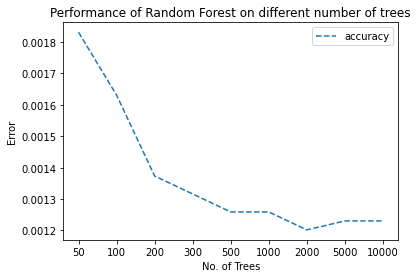

In [296]:
index = np.arange(0,9)
no_trees = [50, 100, 200, 300, 500, 1000, 2000, 5000, 10000]
#plt.plot(index, specificity_list, label = "specificity", linestyle="-")
#plt.plot(index, sensitivity_list, label = "sensitivity", linestyle="-.")
plt.plot(index, error_list, label = "accuracy", linestyle="--")
plt.xlabel('No. of Trees')
plt.ylabel('Error')
plt.xticks(index, no_trees)
plt.title('Performance of Random Forest on different number of trees')
plt.legend()
plt.show()

### Best min_leaf_sample & Max features

In [123]:
accuracy_list = []
specificity_list = []
sensitivity_list = []
no_features = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for j in no_features:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 2, max_features = j, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
    clf.fit(dataset, Y_train)
    prediction = clf.predict(dataset)
    accuracy = accuracy_score(Y_train, prediction)
    accuracy_list.append(accuracy)
    tn, fp, fn, tp = confusion_matrix(Y_train, prediction).ravel()
    specificity_list.append(tn / (tn+fp))
    sensitivity_list.append(tp / (tp+fn))
    print(j)

400 10
400 11
400 12
400 13
400 14
400 15
400 16
400 17
400 18
400 19
400 20


ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

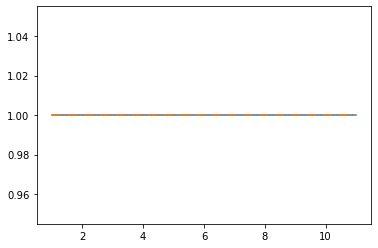

In [272]:
index = range(1,12)
plt.plot(index, specificity_list, label = "specificity", linestyle="-")
plt.plot(index, sensitivity_list, label = "recall", linestyle="-.")
plt.plot(index, accuracy_list, label = "accuracy", linestyle="--")
plt.xlabel('No. of Max Features')
plt.ylabel('Metric')
plt.xticks(index, no_features)
plt.title('Performance of Random Forest on different max_features')
plt.legend()
plt.show()

### Cross-Validate

In [152]:
from sklearn.model_selection import cross_validate
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, dataset, Y_train, cv=5, scoring=scoring)

In [153]:
scores

{'fit_time': array([176.78036904, 160.78935862, 152.10221982, 196.30412436,
        152.607265  ]),
 'score_time': array([0.15782619, 0.14663959, 0.23038054, 0.17913103, 0.25830984]),
 'test_precision_macro': array([0.85756293, 0.96568442, 0.97982575, 0.79690531, 0.8627102 ]),
 'test_recall_macro': array([0.85904948, 0.95962044, 0.97918135, 0.65431985, 0.79214122])}

### RandomizedSearchCV

In [1]:
from sklearn.metrics import make_scorer
# Number of trees in Random Forest
n_estimators = 5000

# Number of features to consider at every split
rf_max_features = ['sqrt', 9, 10, 11, 12, 13, 14,15, 16, 17, 18, 19, 20]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 20, 19)]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'min_samples_split': rf_min_samples_split,}

scoring_list = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
}

NameError: name 'np' is not defined

In [298]:
from sklearn.model_selection import RandomizedSearchCV
# Create the model to be tuned
# Add trees here
rf_base = RandomForestClassifier(n_estimators = 5000)

# Create the random search Random Forest
# n_iter = 20-50
rf_random = RandomizedSearchCV(estimator = rf_base, scoring = scoring_list, param_distributions = rf_grid, refit = 'sensitivity',
                               n_iter = 20, cv = 5, verbose = 3, random_state = 42, 
                               n_jobs = 1)

In [299]:
# Fit the random search model
rf_random.fit(dataset, Y_train)

# View the best parameters from the random search
rf_random.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_features=12, min_samples_split=12, n_estimators=100; accuracy: (test=0.878) sensitivity: (test=0.808) specificity: (test=0.948) total time=  29.2s
[CV 2/5] END max_features=12, min_samples_split=12, n_estimators=100; accuracy: (test=0.920) sensitivity: (test=0.841) specificity: (test=0.999) total time=  28.6s
[CV 3/5] END max_features=12, min_samples_split=12, n_estimators=100; accuracy: (test=0.943) sensitivity: (test=0.888) specificity: (test=0.997) total time=  30.8s
[CV 4/5] END max_features=12, min_samples_split=12, n_estimators=100; accuracy: (test=0.620) sensitivity: (test=0.241) specificity: (test=0.995) total time=  30.9s
[CV 5/5] END max_features=12, min_samples_split=12, n_estimators=100; accuracy: (test=0.795) sensitivity: (test=0.590) specificity: (test=0.997) total time=  30.4s
[CV 1/5] END max_features=14, min_samples_split=17, n_estimators=188; accuracy: (test=0.882) sensitivity: (test=0.816)

[CV 1/5] END max_features=19, min_samples_split=6, n_estimators=211; accuracy: (test=0.874) sensitivity: (test=0.801) specificity: (test=0.947) total time= 1.8min
[CV 2/5] END max_features=19, min_samples_split=6, n_estimators=211; accuracy: (test=0.892) sensitivity: (test=0.785) specificity: (test=0.998) total time= 1.7min
[CV 3/5] END max_features=19, min_samples_split=6, n_estimators=211; accuracy: (test=0.937) sensitivity: (test=0.875) specificity: (test=0.997) total time= 1.9min
[CV 4/5] END max_features=19, min_samples_split=6, n_estimators=211; accuracy: (test=0.604) sensitivity: (test=0.207) specificity: (test=0.996) total time= 1.9min
[CV 5/5] END max_features=19, min_samples_split=6, n_estimators=211; accuracy: (test=0.786) sensitivity: (test=0.572) specificity: (test=0.998) total time= 1.8min
[CV 1/5] END max_features=sqrt, min_samples_split=15, n_estimators=100; accuracy: (test=0.887) sensitivity: (test=0.828) specificity: (test=0.945) total time=  33.6s
[CV 2/5] END max_fe

{'n_estimators': 233, 'min_samples_split': 10, 'max_features': 10}

In [208]:
pd.DataFrame.from_dict(rf_random.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,params,split0_test_accuracy,split1_test_accuracy,...,std_test_sensitivity,rank_test_sensitivity,split0_test_specificity,split1_test_specificity,split2_test_specificity,split3_test_specificity,split4_test_specificity,mean_test_specificity,std_test_specificity,rank_test_specificity
0,80.509276,8.531629,0.275129,0.048097,255,6,12,"{'n_estimators': 255, 'min_samples_split': 6, ...",0.884979,0.920601,...,0.239546,3,0.946215,0.998293,0.997154,0.995162,0.996584,0.986682,0.020258,4
1,63.075479,1.996917,0.230276,0.022308,188,10,12,"{'n_estimators': 188, 'min_samples_split': 10,...",0.884406,0.918026,...,0.237251,2,0.944223,0.998293,0.996870,0.995447,0.996869,0.986340,0.021078,5
2,62.859726,3.544586,0.280027,0.039164,255,4,9,"{'n_estimators': 255, 'min_samples_split': 4, ...",0.885265,0.933047,...,0.236761,1,0.949345,0.998008,0.996870,0.995162,0.996584,0.987194,0.018946,1
3,31.385754,1.364898,0.091314,0.005232,100,5,sqrt,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.877253,0.916595,...,0.243876,5,0.945646,0.998577,0.996870,0.995731,0.997153,0.986796,0.020595,2
4,61.886545,4.569470,0.196867,0.043715,211,7,12,"{'n_estimators': 211, 'min_samples_split': 7, ...",0.880401,0.922461,...,0.242886,4,0.946215,0.998577,0.996870,0.995162,0.996869,0.986739,0.020290,3


### ROC Curve

C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


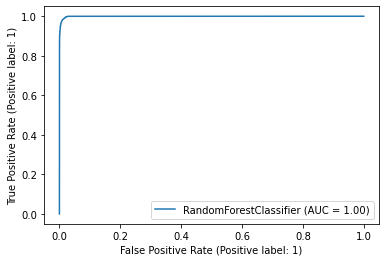

In [147]:
from sklearn import metrics
metrics.plot_roc_curve(clf, dataset, Y_train)

C:\Users\ellen\AppData\Local\R-MINI~1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


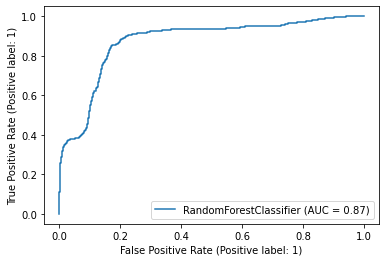

In [146]:
metrics.plot_roc_curve(clf, dataset_test, Y_test)

### Final Model

In [226]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 255, min_samples_leaf = 4, max_features = 9, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
clf.fit(dataset, Y_train)
prediction = clf.predict(dataset)

In [89]:
y_pred = (clf.predict_proba(dataset_test)[:,1] >= 0.25).astype(bool) # set threshold as 0.3

In [227]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, prediction)

array([[17558,    11],
       [    0, 17380]], dtype=int64)

In [69]:
sum(prediction)

17454

In [70]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     17701
           1       0.00      0.91      0.01        11

    accuracy                           0.81     17712
   macro avg       0.50      0.86      0.45     17712
weighted avg       1.00      0.81      0.89     17712



In [117]:
prediction

array([[0.54933327, 0.45066673],
       [0.5502719 , 0.4497281 ],
       [0.54066986, 0.45933014],
       ...,
       [0.99192266, 0.00807734],
       [0.98789979, 0.01210021],
       [0.98820257, 0.01179743]])

In [46]:
indices = [i for i in range(len(Y_test)) if Y_test[i] != y_pred_test[i]]

In [47]:
indices

[0,
 1,
 3,
 4,
 5,
 6,
 10,
 169,
 658,
 663,
 1037,
 1158,
 1162,
 1474,
 1968,
 2137,
 2547,
 2612,
 3021,
 3093,
 3110,
 3637,
 3873,
 3937,
 4007,
 4076,
 4464,
 4750,
 4790,
 5305,
 5400,
 6013,
 6246,
 6262,
 6287,
 6507,
 6647,
 6861,
 6868,
 6908,
 7317,
 7461,
 7699,
 7717,
 7723,
 7875,
 7984,
 8202,
 8207,
 8266,
 8353,
 8514,
 8517,
 8591,
 8747,
 8818,
 8873,
 9050,
 9081,
 9082,
 9115,
 9163,
 9175,
 9189,
 9239,
 9269,
 9281,
 9289,
 9331,
 9370,
 9374,
 9380,
 9480,
 9482,
 9608,
 9818,
 9829,
 9836,
 9852,
 9882,
 9904,
 10012,
 10079,
 10092,
 10171,
 10545,
 10563,
 10568,
 10575,
 10577,
 10639,
 10723,
 10885,
 11091,
 11155,
 11286,
 11299,
 11305,
 11406,
 11433,
 11466,
 11481,
 11483,
 11793,
 12001,
 12569,
 12890,
 15530,
 15877,
 15883,
 15897,
 15976,
 15997,
 16013,
 16059,
 16083,
 16105,
 16316,
 16468,
 16528,
 16535,
 16547,
 16647,
 16749,
 16903,
 16951,
 17046,
 17180,
 17311,
 17320,
 17355,
 17467,
 17592,
 17888,
 18125,
 18308,
 18408,
 18457,


In [49]:
indices_fn = [i for i in range(len(Y_test)) if Y_test[i] == 1]
indices_fn

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [84]:
print(clf.oob_score_)

0.9898314451505941


In [85]:
clf.oob_decision_function_

array([[2.18244867e-02, 9.78175513e-01],
       [2.15484056e-02, 9.78451594e-01],
       [1.27191596e-02, 9.87280840e-01],
       ...,
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99925926e-01, 7.40740741e-05]])

In [289]:
from sklearn import metrics
pred_train = [i[1] for i in clf.oob_decision_function_]

In [254]:
len(probs)

37722

In [259]:
len(probs)

34949

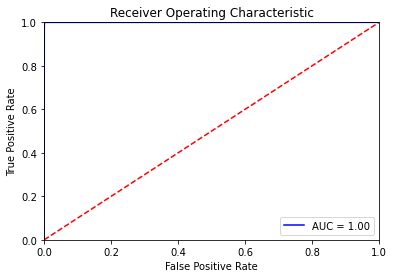

In [261]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(dataset)
preds = clf.oob_decision_function_[:,1]

fpr, tpr, threshold = metrics.roc_curve(Y_train, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test Model

In [228]:
y_pred = (clf.oob_decision_function_[:,1] >= 0.50).astype(bool)

In [229]:
y_pred

array([ True,  True,  True, ..., False, False, False])

In [230]:
[i[1] for i in clf.oob_decision_function_]

[0.9730269730269729,
 0.9709801692560314,
 1.0,
 0.9857142857142857,
 0.9974025974025974,
 0.9976105137395459,
 0.9946428571428572,
 0.9955817378497791,
 0.9985422740524782,
 1.0,
 0.9929924242424242,
 0.9895257248198425,
 0.9929292929292929,
 0.9864253393665159,
 0.9986263736263736,
 0.9883805668016193,
 0.9940476190476191,
 0.9873155416012557,
 0.9927835051546392,
 0.9926108374384237,
 0.9780667701863355,
 0.9852926587301587,
 0.9835775335775336,
 0.9692934782608695,
 0.9962323390894819,
 0.9520438641406381,
 0.9711035123269166,
 0.9913793103448277,
 0.970339412360689,
 0.975172117039587,
 0.9884615384615385,
 0.9944178628389153,
 1.0,
 0.9805555555555555,
 0.99,
 0.9835263835263836,
 0.9732778548312528,
 0.981,
 0.9886363636363636,
 0.9752808988764043,
 0.9875457875457876,
 0.9973118279569892,
 1.0,
 0.9841540404040404,
 0.9870129870129869,
 0.9872340425531916,
 1.0,
 1.0,
 0.981111111111111,
 0.9970238095238095,
 0.9954545454545455,
 0.9903100775193797,
 0.9825476190476189,
 0.9933

In [290]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, y_pred)

array([[17503,    66],
       [    1, 17379]], dtype=int64)

In [86]:
pred = np.argmax(clf.oob_decision_function_,axis=1)

In [87]:
pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [239]:
y_pred_test = (clf.predict_proba(dataset_test)[:,1] >= 0.45).astype(bool) # set threshold as 0.3

In [233]:
prediction_test = clf.predict(dataset_test)

In [176]:
len(dataset_test)

37654

In [178]:
len(Y_test)

37839

In [240]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_pred_test)

array([[37445,   274],
       [    1,     2]], dtype=int64)

In [204]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37831
           1       0.01      0.25      0.02         8

    accuracy                           1.00     37839
   macro avg       0.51      0.62      0.51     37839
weighted avg       1.00      1.00      1.00     37839



In [136]:
y_pred_test = (clf.predict_proba(dataset_test)[:,1] >= 0.).astype(bool) # set threshold as 0.3

In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_pred_test)

array([[9441, 1502],
       [  13,  713]], dtype=int64)

In [138]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     10943
           1       0.32      0.98      0.48       726

    accuracy                           0.87     11669
   macro avg       0.66      0.92      0.71     11669
weighted avg       0.96      0.87      0.90     11669



### Feature Importance

In [38]:
names

Index(['min_T1', 'med_T1', 'mid_T1', 'mid_small_ratio_T1', 'mid_med_ratio_T1',
       'mid_large_ratio_T1', 'mid_small_ratio_T1_inc', 'mid_med_ratio_T1_inc',
       'mid_large_ratio_T1_inc', 'mean_T1', 'max_T1', 'min_FLAIR', 'mid_FLAIR',
       'mean_FLAIR', 'mid_small_ratio_FLAIR', 'mid_med_ratio_FLAIR',
       'mid_large_ratio_FLAIR', 'mid_small_ratio_FLAIR_inc',
       'mid_med_ratio_FLAIR_inc', 'mid_large_ratio_FLAIR_inc', 'med_FLAIR',
       'max_FLAIR', 'density_diff', 'sum_soft_tiss_binary',
       'sum_percent_soft_tiss', 'min_st', 'med_st', 'mid_st',
       'mid_small_ratio_st', 'mid_med_ratio_st', 'mid_large_ratio_st',
       'mid_small_ratio_st_inc', 'mid_med_ratio_st_inc',
       'mid_large_ratio_st_inc', 'mean_st', 'max_st', 'min_th_T1', 'med_th_T1',
       'mid_th_T1', 'mid_small_ratio_th_T1', 'mid_med_ratio_th_T1',
       'mid_large_ratio_th_T1', 'mid_small_ratio_th_T1_inc',
       'mid_med_ratio_th_T1_inc', 'mid_large_ratio_th_T1_inc', 'mean_th_T1',
       'max_th_T1', 

<AxesSubplot:>

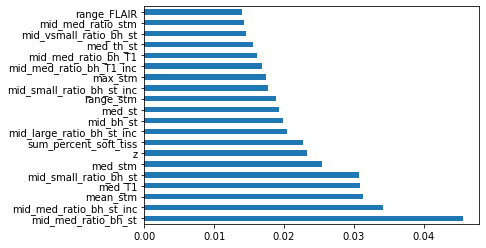

In [175]:
feat_importances = pd.Series(clf.feature_importances_, index=names)
feat_importances.nlargest(20).plot(kind='barh')

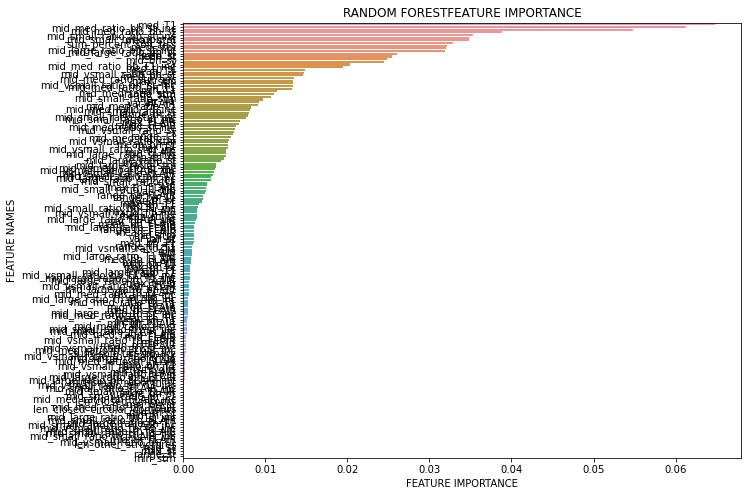

In [77]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(clf.feature_importances_,names,'RANDOM FOREST')

### Thresholding

In [ ]:
from sklearn import metrics
metrics.plot_roc_curve(clf, X_train, y_train) 
plt.show

### Visualisations

In [ ]:
x,y,z = lacune_binary_roty.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'red', s= 10)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_zlim(-0, -20)

In [ ]:
lacune_binary_roty = np.rot90(Y_train_segment[0], axes=(1,2))

### Top hat

In [118]:
filterSize =(16, 16)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                   filterSize)
# Reading the image named 'input.jpg'
input_image = X_test[2][4][:, 10, :]
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, 
                              cv2.MORPH_BLACKHAT,
                              kernel)

plt.imshow(tophat_img, cmap="gray", origin="lower")
plt.show()

IndexError: invalid index to scalar variable.

In [54]:
X_test[2][1]

107

In [55]:
X_test[2][2]

152

In [56]:
X_test[2][3]

107

In [256]:
tophat_img_T1 = cv2.morphologyEx(X_train[4944][4], cv2.MORPH_BLACKHAT,kernel)

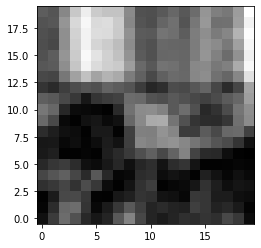

In [258]:
plt.imshow(tophat_img_T1[:, 9, :], cmap="gray", origin="lower")
plt.show()

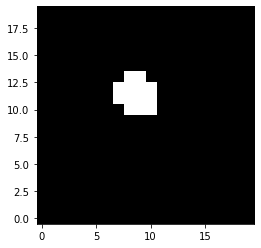

In [123]:
input_image = Y_train_segment[0][:, 10, :]
  
# Applying the Black-Hat operation
#tophat_img = cv2.morphologyEx(input_image, cv2.MORPH_TOPHAT, kernel)

plt.imshow(input_image, cmap="gray", origin="lower")
plt.show()

In [154]:
any(any(row for row in ((X_train[4823][5][:, 10, :])<50)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [200]:
any(1 in sublist for sublist in (X_train[4816][5][:, 10, :]*255<40))

False

In [ ]:
### Testing
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 50, max_features = 12, criterion = 'gini', oob_score = True, bootstrap = True, random_state = 30)
clf.fit(dataset, Y_train)
prediction_test = clf.predict(dataset_test)

In [138]:
import numpy as np

def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

x = np.random.randn(100, 100, 100)
hessian(x)

array([[[[[ 1.64121107e+00,  1.04426078e+00, -5.29906485e-02, ...,
           -1.85958817e-01,  1.14534705e-01,  8.84180713e-01],
          [-3.23028875e-01, -6.07787443e-01,  1.66159403e+00, ...,
            9.42688363e-01, -7.11677886e-01,  3.01688375e-02],
          [ 1.20534005e+00, -1.08224465e+00,  8.96901340e-01, ...,
           -3.79763497e-01,  1.94180718e+00,  1.74502263e+00],
          ...,
          [ 6.65433541e-01,  3.37119478e-01, -7.17403414e-02, ...,
            2.22713586e+00, -8.10485061e-01,  1.97929451e+00],
          [-3.53279674e-01,  2.09976639e+00,  5.97090277e-01, ...,
            6.34847410e-01,  9.04689747e-01,  1.45836958e+00],
          [-1.81770405e+00,  2.48143802e+00, -1.02336252e-01, ...,
           -5.11103701e-01, -1.60059342e-01, -4.37219247e-01]],

         [[ 1.24726441e+00,  5.88569660e-01, -6.60465709e-02, ...,
           -8.29923019e-02,  3.86355897e-02,  3.12834245e-01],
          [ 7.16032535e-02, -2.87160654e-01,  9.99184553e-01, ...,
      

In [139]:
hessian(x).shape

(3, 3, 100, 100, 100)

In [141]:
hessian(x)[:][:][60][50][50]

IndexError: index 60 is out of bounds for axis 0 with size 3

In [132]:
gx, gy, gz = np.gradient(T1_scan_data[1][1])
gxx, gxy, gxz = np.gradient(gx)
gyx, gyy, gyz = np.gradient(gy)
gzx, gzy, gzz = np.gradient(gz)

In [142]:
H_all = np.array([np.gradient(i) for i in np.gradient(T1_scan_data[1][1])]).transpose(2,3,4,0,1)

In [135]:
len(H_all)

256

In [145]:
from numpy import linalg as LA
H_all[100, 80, 90]

array([[ 0.06430054, -0.0379778 ,  0.02876082],
       [-0.0379778 ,  0.02276019, -0.02259324],
       [ 0.02876082, -0.02259324,  0.05973163]])

In [151]:
LA.eig(H_all[105, 148, 104])[0]

array([ 0.02393502, -0.01926139, -0.003875  ])

In [152]:
H_all = np.array([np.gradient(i) for i in np.gradient(FLAIR_scan_data[1][1])]).transpose(2,3,4,0,1)

In [155]:
LA.eig(H_all[105, 148, 104])[0][0]

0.0261294025799085

In [ ]:
from numpy import linalg as LA
H_all[1].eigvalls